In [1]:
"""
CELDA 1: Configuración Inicial y Documentación
=============================================
Objetivo:
- Configurar el entorno para el módulo de prognosis industrial
- Integrar conexión con PostgreSQL para la gestión de datos

Descripción:
Esta celda configura:
1. Conexión a PostgreSQL
2. Herramientas de logging y visualización
3. Parámetros iniciales del proyecto

"""

# Importaciones necesarias
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import logging
import warnings
import os

# Configuración inicial
warnings.filterwarnings("ignore")
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

# Configuración de conexión a PostgreSQL
DB_CONFIG = {
    "user": "postgres",
    "password": "industrial2024",  #contraseña correcta
    "host": "localhost",
    "port": "5432",
    "database": "prognosis_db"
}
DATABASE_URL = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"

def create_db_engine():
    """Crea y retorna un motor de conexión a PostgreSQL"""
    try:
        engine = create_engine(DATABASE_URL)
        logging.info("Conexión a la base de datos configurada correctamente.")
        return engine
    except Exception as e:
        logging.error(f"Error al conectar con la base de datos: {str(e)}")
        return None

# Prueba de conexión
engine = create_db_engine()
if engine:
    try:
        with engine.connect() as conn:
            logging.info("Prueba de conexión exitosa.")
    except Exception as e:
        logging.error(f"Error al probar la conexión: {str(e)}")

print("Configuración inicial completada exitosamente.")


2025-03-29 13:40:01,856 - INFO - Conexión a la base de datos configurada correctamente.
2025-03-29 13:40:01,885 - INFO - Prueba de conexión exitosa.


Configuración inicial completada exitosamente.


In [2]:
"""
CELDA 2: Limpieza, Normalización y Preprocesamiento de Datos
===========================================================
Objetivo:
- Realizar la limpieza inicial, normalización y preprocesamiento de datos.
- Garantizar que los datos sean utilizables para la creación de la línea base y la predicción de fallas.
- Asegurar el manejo correcto de caracteres especiales en variables.

Descripción:
Esta celda implementa:
1. Carga de datos desde archivo o ETL.
2. Limpieza estándar (manejo de valores nulos, tipos de datos y columnas irrelevantes).
3. Normalización de variables numéricas.
4. Validación de la estructura de los datos.
5. Preparación para su inserción en la base de datos PostgreSQL.
6. Manejo robusto de caracteres especiales en nombres de variables.

Características principales:
- Soporte para datos provenientes de archivos o ETL.
- Modularidad para limpieza estándar reutilizable.
- Normalización de variables numéricas.
- Validación de integridad y estructura de los datos.
- Reporte detallado de los cambios realizados.
- Mapeo y trazabilidad de nombres de variables.
"""

# Importaciones necesarias
import pandas as pd
import numpy as np
import logging
from sqlalchemy import text, create_engine
from sklearn.preprocessing import StandardScaler
from typing import Tuple, Dict, Any
import unicodedata
from psycopg2 import connect

# Configuración de conexión a PostgreSQL
DB_CONFIG = {
    "user": "postgres",
    "password": "industrial2024",
    "host": "localhost",
    "port": "5432",
    "database": "prognosis_db"
}

class DatabaseSetup:
    @staticmethod
    def create_database_if_not_exists(config: Dict[str, str]):
        """Crea la base de datos si no existe."""
        try:
            connection = connect(
                dbname="postgres",
                user=config["user"],
                password=config["password"],
                host=config["host"],
                port=config["port"]
            )
            connection.autocommit = True
            cursor = connection.cursor()
            cursor.execute(f"SELECT 1 FROM pg_database WHERE datname = '{config['database']}';")
            if not cursor.fetchone():
                cursor.execute(f"CREATE DATABASE {config['database']};")
                logging.info(f"Base de datos '{config['database']}' creada exitosamente.")
            cursor.close()
            connection.close()
        except Exception as e:
            logging.error(f"Error al crear la base de datos: {str(e)}")
            raise

class DataPreprocessor:
    def __init__(self, db_engine, file_path: str = None):
        """Inicializa la clase de preprocesamiento de datos."""
        self.db_engine = db_engine
        self.file_path = file_path
        self.cleaned_data = None
        self.normalized_data = None
        self.quality_report = {
            'missing_values': {},
            'irrelevant_columns': [],
            'data_types': {},
            'warnings': [],
            'variable_mapping': {}
        }
        self.scaler = StandardScaler()
        self._setup_logging()

    def _setup_logging(self):
        """Configura el sistema de logging."""
        self.logger = logging.getLogger(__name__)
        if not self.logger.handlers:
            handler = logging.StreamHandler()
            formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
            handler.setFormatter(formatter)
            self.logger.addHandler(handler)
            self.logger.setLevel(logging.INFO)

    def _normalize_column_name(self, column: str) -> str:
        """Normaliza el nombre de una columna manteniendo trazabilidad."""
        try:
            # Convertir a minúsculas y eliminar acentos
            normalized = column.lower()
            normalized = unicodedata.normalize('NFKD', normalized)
            normalized = u"".join([c for c in normalized if not unicodedata.combining(c)])
            
            # Reemplazar caracteres especiales con guión bajo
            normalized = ''.join(c if c.isalnum() else '_' for c in normalized)
            normalized = '_'.join(filter(None, normalized.split('_')))
            
            # Guardar mapeo original
            self.quality_report['variable_mapping'][normalized] = column
            
            return normalized
            
        except Exception as e:
            self.logger.error(f"Error normalizando nombre de columna: {str(e)}")
            return column

    def load_data(self) -> pd.DataFrame:
        """Carga datos desde un archivo Excel o CSV."""
        try:
            if not self.file_path:
                raise ValueError("No se proporcionó la ruta del archivo.")

            self.logger.info("Cargando datos desde el archivo...")
            
            # Obtener la extensión del archivo
            file_extension = self.file_path.split('.')[-1].lower()
            
            # Cargar según el tipo de archivo
            if file_extension == 'csv':
                # Intentar cargar CSV con diferentes encodings comunes
                encodings = ['utf-8', 'latin1', 'iso-8859-1']
                for encoding in encodings:
                    try:
                        data = pd.read_csv(self.file_path, encoding=encoding)
                        self.logger.info(f"Archivo CSV cargado exitosamente con encoding {encoding}")
                        break
                    except UnicodeDecodeError:
                        continue
                else:
                    raise ValueError("No se pudo leer el archivo CSV con ningún encoding común")
            
            elif file_extension in ['xlsx', 'xls']:
                data = pd.read_excel(self.file_path)
                self.logger.info("Archivo Excel cargado exitosamente")
            
            else:
                raise ValueError(f"Formato de archivo no soportado: {file_extension}")

            self.logger.info(f"Datos cargados: {data.shape[0]} filas y {data.shape[1]} columnas")
            return data

        except Exception as e:
            self.logger.error(f"Error al cargar datos: {str(e)}")
            return pd.DataFrame()

    def clean_data(self, data: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, Any]]:
        """Limpia los datos eliminando valores nulos, ajustando tipos de datos y reportando cambios."""
        try:
            self.logger.info("Iniciando limpieza de datos...")
            
            # Normalizar nombres de columnas
            data = data.copy()
            data.columns = [self._normalize_column_name(col) for col in data.columns]
                # NUEVO: Análisis detallado de variables constantes
            constant_vars = []
            for col in data.columns:
                unique_values = data[col].nunique()
                if unique_values <= 1:
                    constant_vars.append({
                        "variable": col,
                        "value": data[col].iloc[0],
                        "unique_count": unique_values
                    })
                    
            # Actualizar quality_report con información detallada
            self.quality_report['constant_variables'] = constant_vars
            
            # Identificar y eliminar columnas irrelevantes con más detalle
            irrelevant_cols = [col['variable'] for col in constant_vars]
            if irrelevant_cols:
                self.logger.warning(f"Variables constantes detectadas: {irrelevant_cols}")
                self.quality_report['irrelevant_columns'] = irrelevant_cols
                data.drop(columns=irrelevant_cols, inplace=True)
                # Guardar tipos de datos originales
            self.quality_report['data_types'] = {col: str(data[col].dtype) for col in data.columns}
                # Manejo de valores nulos
            for col in data.columns:
                missing = data[col].isnull().sum()
                self.quality_report['missing_values'][col] = missing
                if missing > 0:
                    if pd.api.types.is_numeric_dtype(data[col]):
                        data[col].fillna(data[col].median(), inplace=True)
                    else:
                        data[col].fillna("Desconocido", inplace=True)
                self.cleaned_data = data
            self.logger.info("Limpieza de datos completada.")
            return data, self.quality_report
        except Exception as e:
            self.logger.error(f"Error durante la limpieza de datos: {str(e)}")
            return pd.DataFrame(), self.quality_report

    def normalize_data(self):
        """Normaliza las variables numéricas."""
        try:
            if self.cleaned_data is None or self.cleaned_data.empty:
                raise ValueError("Los datos no están limpios o están vacíos.")

            numeric_cols = self.cleaned_data.select_dtypes(include=[np.number]).columns
            self.normalized_data = self.cleaned_data.copy()
            self.normalized_data[numeric_cols] = self.scaler.fit_transform(self.cleaned_data[numeric_cols])

            self.logger.info("Normalización de datos completada.")
            return self.normalized_data

        except Exception as e:
            self.logger.error(f"Error durante la normalización de datos: {str(e)}")
            return pd.DataFrame()

    def validate_data(self) -> bool:
        """Valida que los datos estén listos para la inserción en la base de datos."""
        try:
            if self.normalized_data is None or self.normalized_data.empty:
                raise ValueError("Los datos no están listos o están vacíos.")

            if 'timestamp' not in self.normalized_data.columns:
                raise ValueError("Los datos no contienen una columna de 'timestamp'.")

            self.logger.info("Validación de datos exitosa.")
            return True

        except Exception as e:
            self.logger.error(f"Error durante la validación de datos: {str(e)}")
            return False

    def insert_into_db(self, table_name: str):
        """Inserta los datos normalizados en la base de datos PostgreSQL."""
        try:
            if not self.validate_data():
                raise ValueError("Los datos no pasaron la validación.")

            with self.db_engine.connect() as conn:
                with conn.begin():
                    # Crear tabla de mapeo
                    conn.execute(text("""
                        CREATE TABLE IF NOT EXISTS variable_mapping (
                            normalized_name VARCHAR PRIMARY KEY,
                            original_name VARCHAR NOT NULL,
                            data_type VARCHAR,
                            created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
                        );
                    """))
                    
                    # Insertar mapeo de variables
                    for norm_name, orig_name in self.quality_report['variable_mapping'].items():
                        conn.execute(text("""
                            INSERT INTO variable_mapping 
                            (normalized_name, original_name, data_type)
                            VALUES (:norm, :orig, :dtype)
                            ON CONFLICT (normalized_name) DO UPDATE 
                            SET original_name = EXCLUDED.original_name,
                                data_type = EXCLUDED.data_type
                        """), {
                            'norm': norm_name,
                            'orig': orig_name,
                            'dtype': self.quality_report['data_types'].get(norm_name)
                        })

                    # Crear e insertar datos normalizados
                    self.normalized_data.to_sql(
                        table_name, 
                        conn, 
                        if_exists='replace', 
                        index=False,
                        method='multi'
                    )

            self.logger.info(f"Datos insertados exitosamente en la tabla '{table_name}'.")

        except Exception as e:
            self.logger.error(f"Error al insertar datos en la base de datos: {str(e)}")
            raise

def test_preprocessing():
    """Prueba el flujo completo de limpieza, normalización y preprocesamiento."""
    try:
        print("\n=== PRUEBA DE PREPROCESAMIENTO ===\n")

        # Configuración inicial
        file_path = "filtered_consolidated_data_cleaned.xlsx"
        table_name = "normalized_data_table"

        # Crear la base de datos si no existe
        DatabaseSetup.create_database_if_not_exists(DB_CONFIG)

        # Crear el motor de conexión
        DATABASE_URL = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
        engine = create_engine(DATABASE_URL)

        # Crear instancia del preprocesador
        preprocessor = DataPreprocessor(db_engine=engine, file_path=file_path)

        # Ejecutar el flujo completo
        raw_data = preprocessor.load_data()
        cleaned_data, report = preprocessor.clean_data(raw_data)
        normalized_data = preprocessor.normalize_data()
        preprocessor.insert_into_db(table_name)

        # Mostrar reporte de calidad
        print("\nReporte de calidad de datos:")
        for key, value in report.items():
            print(f"{key}: {value}")

        print("\nPreprocesamiento completado exitosamente.")

    except Exception as e:
        print(f"Error en la prueba de preprocesamiento: {str(e)}")

# Ejecutar prueba
if __name__ == "__main__":
    test_preprocessing()

2025-03-29 13:40:02,899 - __main__ - INFO - Cargando datos desde el archivo...
2025-03-29 13:40:02,899 - INFO - Cargando datos desde el archivo...



=== PRUEBA DE PREPROCESAMIENTO ===



2025-03-29 13:40:08,278 - __main__ - INFO - Archivo Excel cargado exitosamente
2025-03-29 13:40:08,278 - INFO - Archivo Excel cargado exitosamente
2025-03-29 13:40:08,281 - __main__ - INFO - Datos cargados: 7141 filas y 57 columnas
2025-03-29 13:40:08,281 - INFO - Datos cargados: 7141 filas y 57 columnas
2025-03-29 13:40:08,287 - __main__ - INFO - Iniciando limpieza de datos...
2025-03-29 13:40:08,287 - INFO - Iniciando limpieza de datos...
2025-03-29 13:40:08,322 - __main__ - INFO - Limpieza de datos completada.
2025-03-29 13:40:08,322 - INFO - Limpieza de datos completada.
2025-03-29 13:40:08,359 - __main__ - INFO - Normalización de datos completada.
2025-03-29 13:40:08,359 - INFO - Normalización de datos completada.
2025-03-29 13:40:08,362 - __main__ - INFO - Validación de datos exitosa.
2025-03-29 13:40:08,362 - INFO - Validación de datos exitosa.
2025-03-29 13:40:25,705 - __main__ - INFO - Datos insertados exitosamente en la tabla 'normalized_data_table'.
2025-03-29 13:40:25,705 -


Reporte de calidad de datos:
missing_values: {'tension_l1_v': np.int64(0), 'tension_l2_v': np.int64(0), 'tension_l3_v': np.int64(0), 'tension_l1_l2_v': np.int64(0), 'tension_l2_l3_v': np.int64(0), 'tension_l3_l1_v': np.int64(0), 'timestamp': np.int64(0), 'corriente_l1_a': np.int64(0), 'corriente_l2_a': np.int64(0), 'corriente_l3_a': np.int64(0), 'factor_de_potencia_l1': np.int64(0), 'factor_de_potencia_l2': np.int64(0), 'factor_de_potencia_l3': np.int64(0), 'flicker_pst_l1_pst': np.int64(0), 'flicker_pst_l2_pst': np.int64(0), 'flicker_pst_l3_pst': np.int64(0), 'distorsion_armonica_vl1_v_thd': np.int64(0), 'distorsion_armonica_vl2_v_thd': np.int64(0), 'distorsion_armonica_vl3_v_thd': np.int64(0), 'distorsion_armonica_il1_i_thd': np.int64(0), 'distorsion_armonica_il2_i_thd': np.int64(0), 'distorsion_armonica_il3_i_thd': np.int64(0), 'armonicos_il1_armonico_2_il1': np.int64(0), 'armonicos_il1_armonico_3_il1': np.int64(0), 'armonicos_il1_armonico_5_il1': np.int64(0), 'armonicos_il1_armoni

In [3]:
"""
Fase 2: Identificación de Variables Clave
========================================

Objetivos:
1. Identificar y registrar variables clave para prognosis en PostgreSQL.
2. Implementar un sistema robusto de selección y seguimiento de variables.
3. Mantener histórico de cambios en las variables seleccionadas.
4. Generar reportes detallados de análisis.

Características:
- Análisis multifactorial de variables.
- Sistema de puntuación ponderado.
- Registro histórico con timestamps.
- Validación y logging exhaustivo.
- Creación robusta de la base de datos y tablas.
"""

# Importaciones necesarias
import numpy as np
import pandas as pd
from sqlalchemy import create_engine, text
from sqlalchemy.exc import OperationalError, ProgrammingError
from psycopg2 import connect
from typing import Dict, Any, List
import logging
from datetime import datetime

class DatabaseSetup:
    @staticmethod
    def create_database_if_not_exists(config: Dict[str, str]):
        """Crea la base de datos si no existe."""
        try:
            connection = connect(
                dbname="postgres",
                user=config["user"],
                password=config["password"],
                host=config["host"],
                port=config["port"]
            )
            connection.autocommit = True
            cursor = connection.cursor()
            cursor.execute(f"SELECT 1 FROM pg_database WHERE datname = '{config['database']}';")
            if not cursor.fetchone():
                cursor.execute(f"CREATE DATABASE {config['database']};")
                logging.info(f"Base de datos '{config['database']}' creada exitosamente.")
            cursor.close()
            connection.close()
        except Exception as e:
            logging.error(f"Error al crear la base de datos: {str(e)}")
            raise

class KeyVariableSelector:
    def __init__(self, db_engine, table_name: str):
        """Inicializa el selector de variables clave."""
        self.db_engine = db_engine
        self.table_name = table_name
        self.mapping_table = "variable_mapping"
        self.history_table = "selected_variables_history"
        self.analysis_table = "variable_analysis_history"
        self.logger = self._setup_logging()
        self.variable_mapping = {}
        self.results = {
            "selected_variables": {},
            "variable_scores": {},
            "removed_variables": [],
            "new_variables": [],
            "analysis_timestamp": datetime.now()
        }
        self._validate_db_connection()
        self._create_tables()

    def _setup_logging(self):
        """Configura el sistema de logging."""
        logger = logging.getLogger(__name__)
        if not logger.handlers:
            handler = logging.StreamHandler()
            formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
            handler.setFormatter(formatter)
            logger.addHandler(handler)
            logger.setLevel(logging.INFO)
        return logger

    def _validate_db_connection(self):
        """Valida la conexión con la base de datos."""
        try:
            with self.db_engine.connect() as conn:
                self.logger.info("Conexión con la base de datos validada correctamente.")
        except OperationalError as e:
            self.logger.error(f"Error al conectar con la base de datos: {str(e)}")
            raise

    def _create_tables(self):
        """Crea las tablas necesarias en la base de datos."""
        try:
            with self.db_engine.connect() as conn:
                with conn.begin():
                    # Tabla para histórico de variables seleccionadas
                    conn.execute(text(f"""
                        CREATE TABLE IF NOT EXISTS {self.history_table} (
                            id SERIAL PRIMARY KEY,
                            variable_name TEXT NOT NULL,
                            original_name TEXT NOT NULL,
                            importance_score FLOAT NOT NULL,
                            category TEXT NOT NULL,
                            timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                            UNIQUE(variable_name, timestamp)
                        );
                    """))
                    
                    # Tabla para histórico de análisis
                    conn.execute(text(f"""
                        CREATE TABLE IF NOT EXISTS {self.analysis_table} (
                            id SERIAL PRIMARY KEY,
                            variable_name TEXT NOT NULL,
                            original_name TEXT NOT NULL,
                            variance_score FLOAT,
                            stability_score FLOAT,
                            trend_score FLOAT,
                            correlation_score FLOAT,
                            final_score FLOAT,
                            timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP
                        );
                    """))
            self.logger.info("Tablas creadas/verificadas exitosamente.")
        except Exception as e:
            self.logger.error(f"Error creando tablas: {str(e)}")
            raise

    def load_data(self) -> pd.DataFrame:
        """Carga datos y mantiene trazabilidad de nombres."""
        try:
            with self.db_engine.connect() as conn:
                # Cargar datos normalizados
                query = f"SELECT * FROM {self.table_name};"
                data = pd.read_sql_query(query, conn)
                
                # Cargar mapeo de variables
                mapping_query = f"SELECT normalized_name, original_name FROM {self.mapping_table};"
                variable_mapping = pd.read_sql_query(mapping_query, conn)
                
            # Validaciones
            if data.empty:
                raise ValueError("No se encontraron datos en la tabla.")
            if 'timestamp' not in data.columns:
                raise ValueError("La tabla debe contener una columna 'timestamp'.")
                
            # Configurar índice temporal
            data.set_index('timestamp', inplace=True)
            
            # Guardar mapeo para uso posterior
            self.variable_mapping = dict(zip(variable_mapping['normalized_name'], 
                                          variable_mapping['original_name']))
            
            self.logger.info(f"Datos cargados: {data.shape[0]} filas y {data.shape[1]} columnas.")
            return data
            
        except Exception as e:
            self.logger.error(f"Error al cargar datos: {str(e)}")
            raise

    def calculate_variable_score(self, series: pd.Series) -> float:
        """Calcula el score inicial de una variable y valida si es utilizable."""
        try:
            # 1. Verificación de valores únicos sin NaN
            unique_values = series.dropna().unique()
            n_unique = len(unique_values)
            total_values = len(series.dropna())
            
            self.logger.debug(f"Evaluando {series.name}:")
            self.logger.debug(f"- Valores únicos: {n_unique}")
            
            # Filtrar variables con muy pocos valores únicos
            if n_unique <= 3:  # Aumentamos el umbral mínimo de valores únicos
                self.logger.warning(f"Variable {series.name} tiene muy pocos valores únicos ({n_unique})")
                return 0.0
                
            # Calcular ratio de valores únicos
            unique_ratio = n_unique / total_values
            if unique_ratio < 0.001:  # Si menos del 0.1% de valores son únicos
                self.logger.warning(f"Variable {series.name} tiene ratio de valores únicos muy bajo ({unique_ratio:.6f})")
                return 0.0
                
            # 2. Verificación de varianza
            variance = series.var()
            self.logger.debug(f"- Varianza: {variance}")
            
            if abs(variance) < 1e-6:  # Aumentamos el umbral de varianza mínima
                self.logger.warning(f"Variable {series.name} tiene varianza prácticamente nula ({variance})")
                return 0.0
                
            # 3. Cálculo del score considerando tanto varianza como diversidad de valores
            score = float(np.log1p(abs(variance))) * unique_ratio
            return score
            
        except Exception as e:
            self.logger.error(f"Error calculando score para {series.name}: {str(e)}")
            return 0.0
    def _analyze_single_variable(self, series: pd.Series, data: pd.DataFrame) -> Dict[str, float]:
        """Analiza una variable individual con múltiples métricas."""
        try:
            # 1. Score inicial de variabilidad
            variance_score = self.calculate_variable_score(series)
            
            # Si no pasa la validación inicial, retornamos scores en cero
            if variance_score == 0:
                self.logger.warning(f"Variable {series.name} no pasó validación inicial")
                return self._get_zero_scores()

            # 2. Cálculo de métricas adicionales
            try:
                # Estabilidad temporal
                rolling_std = series.rolling(window=24, min_periods=1).std().mean()
                total_std = series.std()
                stability_score = float(1 - ( rolling_std / total_std) if total_std > 0 else 0)
                    # Tendencia
                trend_score = float(abs(np.polyfit(np.arange(len(series)), series, 1)[0]))
                    # Correlación con otras variables
                correlations = data.corrwith(series).abs()
                correlation_score = float(correlations.mean())
                    # 3. Score final ponderado
                scores = {
                    "variance_score": variance_score,
                    "stability_score": stability_score,
                    "trend_score": trend_score,
                    "correlation_score": correlation_score
                }
                
                weights = {
                    "variance_score": 0.3,
                    "stability_score": 0.3,
                    "trend_score": 0.2,
                    "correlation_score": 0.2
                }
                
                final_score = sum(score * weights[name] for name, score in scores.items())
                return {**scores, "final_score": float(final_score)}
            except Exception as calc_error:
                self.logger.error(f"Error en cálculo de métricas para {series.name}: {calc_error}")
                return self._get_zero_scores()
        except Exception as e:
            self.logger.error(f"Error en análisis de {series.name}: {str(e)}")
            return self._get_zero_scores()
    def analyze_variables(self, data: pd.DataFrame) -> Dict[str, Any]:
        """Realiza análisis completo de variables."""
        try:
            self.logger.info("Iniciando análisis de variables...")
            analysis_results = []
            constant_variables = []
            scores_dict = {}
                # Análisis individual de variables
            for col in data.columns:
                series = data[col].copy()
                
                # Estadísticas básicas para logging
                unique_vals = series.dropna().unique()
                variance = series.var()
                self.logger.info(f"\nAnalizando {col}:")
                self.logger.info(f"- Valores únicos: {len(unique_vals)}")
                self.logger.info(f"- Muestra valores: {unique_vals[:5]}")
                self.logger.info(f"- Varianza: {variance}")
                
                # Análisis completo
                scores = self._analyze_single_variable(series, data)
                
                # Logging de scores
                for score_name, score_value in scores.items():
                    self.logger.info(f"- {score_name}: {score_value}")
                
                # Clasificación de la variable
                if scores["final_score"] == 0:
                    reason = "Variable constante" if len(unique_vals) <= 1 else "Varianza nula"
                    value = str(series.iloc[0]) if not series.empty else "NA"
                    
                    self.logger.warning(f"Variable descartada: {col}")
                    self.logger.warning(f"Razón: {reason}")
                    
                    constant_variables.append({
                        "variable": col,
                        "reason": reason,
                        "value": value,
                        "variance": float(variance)
                    })
                    continue
                
                # Registro de variables válidas
                scores_dict[col] = scores["final_score"]
                analysis_results.append({
                    "variable_name": col,
                    "original_name": self.variable_mapping.get(col, col),
                    **scores
                })
                # Actualización de resultados
            self.results.update({
                "variable_scores": scores_dict,
                "removed_variables": constant_variables
            })
                # Proceso final
            self._categorize_variables(data)
            self._save_analysis_results(analysis_results)
            self.validate_selected_variables()
            
            return self.results
        except Exception as e:
            self.logger.error(f"Error en análisis de variables: {str(e)}")
            raise
    def _get_zero_scores(self) -> Dict[str, float]:
        """Retorna un diccionario con todos los scores en cero."""
        return {
            "variance_score": 0.0,
            "stability_score": 0.0,
            "trend_score": 0.0,
            "correlation_score": 0.0,
            "final_score": 0.0
        }

    def _categorize_variables(self, data: pd.DataFrame):
        """Categoriza variables en críticas y monitoreo."""
        try:
            # 1. Obtener scores y variables removidas
            scores = pd.Series(self.results["variable_scores"])
            removed_vars = set(v["variable"] for v in self.results.get("removed_variables", []))
            
            # 2. Logging inicial de variables removidas
            if removed_vars:
                self.logger.info(f"Variables excluidas de categorización: {sorted(list(removed_vars))}")
            
            # 3. Filtrado estricto de variables válidas
            valid_scores = scores[
                (scores > 0) & (~scores.index.isin(removed_vars))
            ]
        
            if valid_scores.empty:
                self.logger.warning("No hay variables válidas para categorizar")
                return
            
            # 4. Verificación de seguridad
            if set(valid_scores.index).intersection(removed_vars):
                self.logger.error("¡ALERTA! Variables removidas encontradas en scores válidos")
                valid_scores = valid_scores[~valid_scores.index.isin(removed_vars)]
            
            if valid_scores.empty:
                self.logger.warning("No hay variables válidas para categorizar")
                return
            
            # 5. Cálculo de umbrales y categorización
            thresholds = {
                "critical": valid_scores.quantile(0.8),
                "monitoring": valid_scores.quantile(0.5)
            }
                # 6. Reset y categorización de variables
            self.results["selected_variables"] = {}
            for var, score in valid_scores.items():
                if score >= thresholds["critical"]:
                    category = "critical"
                elif score >= thresholds["monitoring"]:
                    category = "monitoring"
                else:
                    continue
                    
                self.results["selected_variables"][var] = {
                    "category": category,
                    "score": float(score),
                    "threshold_used": thresholds[category],
                    "timestamp": datetime.now().isoformat()
                }
                # 7. Registro de métricas finales
            self.results["categorization_metrics"] = {
                "total_variables": len(data.columns),  # Total original
                "analyzed_variables": len(scores),     # Variables analizadas
                "valid_variables": len(valid_scores),  # Variables válidas
                "removed_variables": len(removed_vars),# Variables removidas
                "critical_variables": len([v for v in self.results["selected_variables"].values() 
                                        if v["category"] == "critical"]),
                "monitoring_variables": len([v for v in self.results["selected_variables"].values() 
                                            if v["category"] == "monitoring"]),
                "thresholds": thresholds,
                "removed_list": sorted(list(removed_vars))
            }
                # 8. Logging detallado final
            self.logger.info(f"""
            === RESUMEN FINAL DE CATEGORIZACIÓN ===
            Total variables originales: {self.results['categorization_metrics']['total_variables']}
            Variables analizadas: {self.results['categorization_metrics']['analyzed_variables']}
            Variables removidas: {self.results['categorization_metrics']['removed_variables']}
            Variables válidas: {self.results['categorization_metrics']['valid_variables']}
            Variables críticas: {self.results['categorization_metrics']['critical_variables']}
            Variables en monitoreo: {self.results['categorization_metrics']['monitoring_variables']}
            Variables descartadas: {self.results['categorization_metrics']['removed_list']}
            =====================================
            """)
        except Exception as e:
            self.logger.error(f"Error en categorización de variables: {str(e)}")
            raise

    def validate_selected_variables(self) -> bool:
        """Validación adicional de variables seleccionadas."""
        try:
            for var, details in self.results["selected_variables"].items():
                if details["score"] == 0:
                    self.logger.error(f"Variable {var} con score 0 detectada en selección")
                    del self.results["selected_variables"][var]  # Se agregó 'del'
            return True
        except Exception as e:
            self.logger.error(f"Error en validación: {str(e)}")
            return False

    def _save_analysis_results(self, analysis_results: List[Dict[str, Any]]):
        """Guarda resultados detallados del análisis."""
        try:
            with self.db_engine.connect() as conn:
                with conn.begin():
                    for result in analysis_results:
                        result = {k: float(v) if isinstance(v, (np.float64, np.float32)) else v 
                                for k, v in result.items()}
                        conn.execute(text(f"""
                            INSERT INTO {self.analysis_table} 
                            (variable_name, original_name, variance_score, stability_score, 
                             trend_score, correlation_score, final_score)
                            VALUES (:variable_name, :original_name, :variance_score, 
                                    :stability_score, :trend_score, :correlation_score, :final_score)
                        """), result)
        except Exception as e:
            self.logger.error(f"Error guardando análisis: {str(e)}")
            raise

    def save_results(self):
        """Guarda las variables seleccionadas manteniendo trazabilidad."""
        try:
            with self.db_engine.connect() as conn:
                with conn.begin():
                    for var, details in self.results["selected_variables"].items():
                        # Usar nombre original en el registro
                        original_name = self.variable_mapping.get(var, var)
                        
                        query = text(f"""
                            INSERT INTO {self.history_table} 
                            (variable_name, original_name, importance_score, category)
                            VALUES (:variable_name, :original_name, :importance_score, :category)
                            ON CONFLICT (variable_name, timestamp)
                            DO UPDATE SET
                                importance_score = EXCLUDED.importance_score,
                                category = EXCLUDED.category;
                        """)
                        
                        conn.execute(query, {
                            "variable_name": var,
                            "original_name": original_name,
                            "importance_score": float(details["score"]),
                            "category": details["category"]
                        })
                        
        except Exception as e:
            self.logger.error(f"Error al guardar resultados: {str(e)}")
            raise

# Ejecución
if __name__ == "__main__":
    try:
        DB_CONFIG = {
            "user": "postgres",
            "password": "industrial2024",
            "host": "localhost",
            "port": "5432",
            "database": "prognosis_db"
        }

        # Crear la base de datos si no existe
        DatabaseSetup.create_database_if_not_exists(DB_CONFIG)

        # Crear el motor de conexión
        DATABASE_URL = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
        engine = create_engine(DATABASE_URL)
        
        # Ejecutar el flujo
        selector = KeyVariableSelector(engine, "normalized_data_table")
        data = selector.load_data()
        selector.analyze_variables(data)
        selector.save_results()
    except Exception as e:
        logging.error(f"Error ejecutando flujo: {str(e)}")

2025-03-29 13:40:25,851 - __main__ - INFO - Conexión con la base de datos validada correctamente.
2025-03-29 13:40:25,851 - INFO - Conexión con la base de datos validada correctamente.
2025-03-29 13:40:25,859 - __main__ - INFO - Tablas creadas/verificadas exitosamente.
2025-03-29 13:40:25,859 - INFO - Tablas creadas/verificadas exitosamente.
2025-03-29 13:40:26,360 - __main__ - INFO - Datos cargados: 7141 filas y 56 columnas.
2025-03-29 13:40:26,360 - INFO - Datos cargados: 7141 filas y 56 columnas.
2025-03-29 13:40:26,371 - __main__ - INFO - Iniciando análisis de variables...
2025-03-29 13:40:26,371 - INFO - Iniciando análisis de variables...
2025-03-29 13:40:26,381 - __main__ - INFO - 
Analizando tension_l1_v:
2025-03-29 13:40:26,381 - INFO - 
Analizando tension_l1_v:
2025-03-29 13:40:26,384 - __main__ - INFO - - Valores únicos: 1081
2025-03-29 13:40:26,384 - INFO - - Valores únicos: 1081
2025-03-29 13:40:26,390 - __main__ - INFO - - Muestra valores: [-0.12807509 -0.00177156  0.01859

In [4]:
"""
FASE 3: Sistema Robusto de Línea Base Adaptativa Incremental
=========================================================

Objetivo: Establecer líneas base robustas y adaptativas para variables clave
Versión: 5.0
Descripción: Sistema avanzado de modelado de comportamiento normal con:
- Procesamiento incremental por lotes
- Ensemble de modelos estadísticos y ML
- Detección automática de patrones y regímenes
- Validación temporal rigurosa 
- Control de versiones de modelos
- Preparación para predicción de fallas
"""

import numpy as np
import pandas as pd
from sqlalchemy import create_engine, text, MetaData
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, RobustScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import stats
from prophet import Prophet
from typing import Dict, List, Any, Tuple, Optional
import logging
from datetime import datetime, timedelta
import json
import warnings
from concurrent.futures import ThreadPoolExecutor
warnings.filterwarnings('ignore')


# Configuración del sistema
class SystemConfig:
    def __init__(self):
        # Configuración de BD
        self.DB_CONFIG = {
            "user": "postgres",
            "password": "industrial2024",
            "host": "localhost", 
            "port": "5432",
            "database": "prognosis_db"
        }
        
        # Parámetros del modelo
        self.MODEL_PARAMS = {
            "training_window": "90D",
            "update_frequency": "1D",
            "min_data_points": 1000,
            "confidence_level": 0.95,
            "seasonality_test_size": 168,
            "batch_size": 1000,  # Tamaño del lote para procesamiento incremental
            "max_versions": 5     # Número máximo de versiones a mantener
        }
        
        # Umbrales estadísticos
        self.STATISTICAL_THRESHOLDS = {
            "stationarity_pvalue": 0.05,
            "seasonality_strength": 0.3,
            "outlier_std_dev": 3,
            "minimum_variance_ratio": 0.01,
            "learning_threshold": 0.1  # Umbral para considerar mejora significativa
        }
        
        # Tablas de BD
        self.TABLES = {
            "input": {
                "normalized_data": "normalized_data_table",
                "selected_variables": "selected_variables_history"
            },
            "output": {
                "baseline": "baseline_models",
                "patterns": "pattern_registry", 
                "metrics": "baseline_metrics",
                "validation": "baseline_validation",
                "incremental": "baseline_incremental_control",
                "versions": "baseline_model_versions"
            }
        }
class DatabaseManager:
    def __init__(self, config: SystemConfig):
        self.config = config
        self.engine = self._create_engine()
        self.metadata = MetaData()
        self._create_tables()
        
    def _create_engine(self):
        url = f"postgresql://{self.config.DB_CONFIG['user']}:{self.config.DB_CONFIG['password']}@{self.config.DB_CONFIG['host']}:{self.config.DB_CONFIG['port']}/{self.config.DB_CONFIG['database']}"
        return create_engine(url)
    
    def _create_tables(self):
        with self.engine.begin() as conn:
            conn.execute(text("""
                -- Tabla para modelos base
                CREATE TABLE IF NOT EXISTS baseline_models (
                    id SERIAL PRIMARY KEY,
                    variable_name TEXT NOT NULL,
                    model_type TEXT NOT NULL,
                    model_parameters JSONB,
                    baseline_stats JSONB,
                    confidence_intervals JSONB,
                    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                    updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                    is_active BOOLEAN DEFAULT true,
                    UNIQUE(variable_name, model_type)
                );

                -- Tabla para registro de patrones
                CREATE TABLE IF NOT EXISTS pattern_registry (
                    id SERIAL PRIMARY KEY,
                    variable_name TEXT NOT NULL,
                    pattern_type TEXT NOT NULL,
                    pattern_params JSONB,
                    detection_date TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                    confidence_score FLOAT,
                    UNIQUE(variable_name, pattern_type)
                );

                -- Tabla para métricas
                CREATE TABLE IF NOT EXISTS baseline_metrics (
                    id SERIAL PRIMARY KEY,
                    variable_name TEXT NOT NULL,
                    metric_type TEXT NOT NULL,
                    metric_value FLOAT,
                    calculation_date TIMESTAMP DEFAULT CURRENT_TIMESTAMP
                );

                -- Tabla para validación
                CREATE TABLE IF NOT EXISTS baseline_validation (
                    id SERIAL PRIMARY KEY,
                    variable_name TEXT NOT NULL,
                    validation_type TEXT NOT NULL,
                    validation_result JSONB,
                    validation_date TIMESTAMP DEFAULT CURRENT_TIMESTAMP
                );

                -- Nueva tabla para control incremental
                CREATE TABLE IF NOT EXISTS baseline_incremental_control (
                    id SERIAL PRIMARY KEY,
                    variable_name TEXT NOT NULL,
                    last_processed_timestamp TIMESTAMP,
                    batch_number INTEGER DEFAULT 0,
                    batch_size INTEGER,
                    learning_metrics JSONB,
                    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                    updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                    UNIQUE(variable_name)
                );

                -- Nueva tabla para versiones de modelos
                CREATE TABLE IF NOT EXISTS baseline_model_versions (
                    id SERIAL PRIMARY KEY,
                    variable_name TEXT NOT NULL,
                    version INTEGER,
                    model_parameters JSONB,
                    performance_metrics JSONB,
                    training_metadata JSONB,
                    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                    is_active BOOLEAN DEFAULT true,
                    UNIQUE(variable_name, version)
                );

                CREATE TABLE IF NOT EXISTS baseline_quality_reports (
                    id SERIAL PRIMARY KEY,
                    variable_name TEXT NOT NULL,
                    report_data JSONB NOT NULL,
                    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
                );
    
                CREATE INDEX IF NOT EXISTS idx_quality_reports_variable 
                    ON baseline_quality_reports(variable_name);
                    
                    CREATE INDEX IF NOT EXISTS idx_quality_reports_date 
                    ON baseline_quality_reports(created_at);                           

            """))

    def get_selected_variables(self) -> List[str]:
        """Obtiene variables críticas del último análisis"""
        query = """
            WITH LastAnalysisTime AS (
                SELECT MAX(timestamp) as max_time 
                FROM selected_variables_history
            )
            SELECT variable_name 
            FROM selected_variables_history
            WHERE timestamp = (SELECT max_time FROM LastAnalysisTime)
            AND category = 'critical';
        """
        try:
            with self.engine.connect() as conn:
                result = conn.execute(text(query))
                variables = [row[0] for row in result]
                
                # Si no hay variables críticas, obtener todas las numéricas
                if not variables:
                    numeric_query = """
                        SELECT column_name 
                        FROM information_schema.columns 
                        WHERE table_name = 'normalized_data_table'
                        AND column_name != 'timestamp'
                        AND data_type in ('integer', 'numeric', 'double precision', 'real');
                    """
                    result = conn.execute(text(numeric_query))
                    variables = [row[0] for row in result]
                    
                logging.info(f"Variables identificadas: {len(variables)}")
                return variables
        except Exception as e:
            logging.error(f"Error obteniendo variables: {str(e)}")
            return []
    def get_variable_data_batch(self, variable_name: str, last_timestamp: Optional[datetime] = None, 
                          batch_size: int = 1000) -> pd.DataFrame:
        """Obtiene datos de la variable en lotes"""
        if last_timestamp is None:
            query = f"""
                SELECT timestamp::timestamp as timestamp, {variable_name}
                FROM {self.config.TABLES['input']['normalized_data']}
                ORDER BY timestamp
                LIMIT {batch_size};
            """
            params = {}
        else:
            query = f"""
                SELECT timestamp::timestamp as timestamp, {variable_name}
                FROM {self.config.TABLES['input']['normalized_data']}
                WHERE timestamp::timestamp > :last_timestamp
                ORDER BY timestamp
                LIMIT {batch_size};
            """
            params = {"last_timestamp": last_timestamp}
        
        return pd.read_sql_query(text(query), self.engine, 
                            params=params,
                            parse_dates=['timestamp'])

    def get_last_processed_timestamp(self, variable_name: str) -> Optional[datetime]:
        """Obtiene el último timestamp procesado para una variable"""
        query = """
            SELECT last_processed_timestamp
            FROM baseline_incremental_control
            WHERE variable_name = :variable_name;
        """
        try:
            with self.engine.connect() as conn:
                result = conn.execute(text(query), {"variable_name": variable_name})
                row = result.fetchone()
                return row[0] if row else None
        except Exception as e:
            logging.error(f"Error obteniendo último timestamp: {str(e)}")
            return None
    def get_data_statistics(self) -> dict:
        """Obtiene estadísticas de los datos en la base"""
        # Primero obtenemos las columnas de la tabla
        columns_query = """
            SELECT column_name 
            FROM information_schema.columns 
            WHERE table_name = 'normalized_data_table'
            AND column_name != 'timestamp';
        """
        
        general_query = """
            SELECT 
                COUNT(*) as total_records,
                MIN(timestamp)::timestamp as start_date,
                MAX(timestamp)::timestamp as end_date,
                COUNT(DISTINCT timestamp) as unique_timestamps
            FROM normalized_data_table;
        """
        
        try:
            with self.engine.connect() as conn:
                # Obtener lista de columnas
                columns = [row[0] for row in conn.execute(text(columns_query))]
                
                # Estadísticas generales
                result = conn.execute(text(general_query)).fetchone()
                
                # Verificar que result no sea None y las fechas sean válidas
                if result is None:
                    raise ValueError("No se encontraron datos en la tabla")

                start_date = result[1]
                end_date = result[2]

                stats = {
                    "total_records": result[0],
                    "date_range": {
                        "start": start_date.isoformat() if start_date else None,
                        "end": end_date.isoformat() if end_date else None
                    },
                    "unique_timestamps": result[3],
                    "num_columns": len(columns)
                }
                
                # Estadísticas por variable
                var_stats = {}
                for column in columns:
                    var_query = f"""
                        SELECT 
                            COUNT(*) as total,
                            COUNT(CASE WHEN {column} IS NOT NULL THEN 1 END) as non_null_count,
                            COUNT(CASE WHEN {column} IS NOT NULL THEN 1 END) * 100.0 / NULLIF(COUNT(*), 0) as completeness_pct
                        FROM normalized_data_table;
                    """
                    var_result = conn.execute(text(var_query)).fetchone()
                    if var_result:
                        var_stats[column] = {
                            "non_null_count": var_result[1],
                            "completeness": f"{var_result[2]:.2f}%" if var_result[2] is not None else "0.00%"
                        }
                
                stats["variables"] = var_stats
                
                logging.info(f"""
                Estadísticas de datos:
                - Total registros: {stats['total_records']:,}
                - Rango: {stats['date_range']['start']} a {stats['date_range']['end']}
                - Timestamps únicos: {stats['unique_timestamps']:,}
                - Variables: {stats['num_columns']}
                """)
                
                # Agregar detalle de variables
                logging.info("\nEstadísticas por variable:")
                for var, var_stat in var_stats.items():
                    logging.info(f"- {var}: {var_stat['completeness']} completitud ({var_stat['non_null_count']:,} registros)")
                
                return stats
                    
        except Exception as e:
            logging.error(f"Error obteniendo estadísticas: {str(e)}")
            return {}

    def get_adaptive_limits(self, variable_name: str) -> Dict[str, float]:
        """Calcula límites adaptativos para cada variable"""
        try:
            # Modificar la consulta para usar directamente el nombre de la variable como columna
            query = f"""
                WITH stats AS (
                    SELECT 
                        AVG({variable_name}) as mean,
                        STDDEV({variable_name}) as std,
                        PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY {variable_name}) as q1,
                        PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY {variable_name}) as q3
                    FROM normalized_data_table
                    WHERE timestamp >= NOW() - INTERVAL '30 days'
                )
                SELECT 
                    mean, std, q1, q3,
                    q3 - q1 as iqr
                FROM stats;
            """
            
            with self.engine.connect() as conn:
                result = conn.execute(text(query)).fetchone()
                
                if result:
                    mean, std, q1, q3, iqr = result
                    
                    return {
                        'baseline': float(mean) if mean is not None else 0.0,
                        'upper': float(q3 + 1.5 * iqr) if q3 is not None and iqr is not None else 0.0,
                        'lower': float(q1 - 1.5 * iqr) if q1 is not None and iqr is not None else 0.0,
                        'std': float(std) if std is not None else 0.0,
                        'iqr': float(iqr) if iqr is not None else 0.0
                    }
                else:
                    logging.warning(f"No hay datos suficientes para {variable_name}")
                    return None
                    
        except Exception as e:
            logging.error(f"Error calculando límites para {variable_name}: {str(e)}")
            return None

    def update_variable_limits(self, variable_name: str) -> bool:
        """Actualiza los límites de forma periódica"""
        try:
            new_limits = self.get_adaptive_limits(variable_name)
            if new_limits:
                with self.engine.begin() as conn:
                    conn.execute(text("""
                        UPDATE baseline_models 
                        SET baseline_stats = :stats::jsonb,
                            updated_at = CURRENT_TIMESTAMP
                        WHERE variable_name = :variable
                        AND is_active = true;
                    """), {
                        'variable': variable_name,
                        'stats': json.dumps(new_limits)
                    })
                logging.info(f"Límites actualizados para {variable_name}")
                return True
            return False
        except Exception as e:
            logging.error(f"Error actualizando límites: {str(e)}")
            return False

    def get_all_variable_limits(self) -> Dict[str, Dict[str, float]]:
        """Obtiene los límites actuales de todas las variables"""
        try:
            query = """
                SELECT variable_name, baseline_stats::jsonb as stats
                FROM baseline_models 
                WHERE is_active = true;
            """
            
            limits = {}
            with self.engine.connect() as conn:
                result = conn.execute(text(query))
                for row in result:
                    limits[row['variable_name']] = row['stats']
            
            return limits
        except Exception as e:
            logging.error(f"Error obteniendo límites: {str(e)}")
            return {}    
class BaselineModeler:
    def __init__(self, config: SystemConfig, db_manager: DatabaseManager):
        self.config = config
        self.db = db_manager
        self.models = {}
        self.scalers = {}
        self.patterns = {}
    
    def save_results(self, variable_name: str, results: Dict[str, Any]):
        """Guarda los resultados del modelo y crea una nueva versión en una única transacción"""
        try:
            # Limpiar datos antes de serializar
            clean_results = {
                "patterns": self._clean_json_data(results["patterns"]),
                "metrics": self._clean_json_data(results["metrics"]),
                "validation": self._clean_json_data(results["validation"])
            }

            with self.db.engine.begin() as conn:
                # Todo en una única transacción
                # 1. Guardar modelo base
                conn.execute(text("""
                    INSERT INTO baseline_models 
                    (variable_name, model_type, model_parameters, baseline_stats, 
                    confidence_intervals)
                    VALUES (:variable_name, 'ensemble', :model_params, :stats, :intervals)
                    ON CONFLICT (variable_name, model_type) DO UPDATE 
                    SET model_parameters = EXCLUDED.model_parameters,
                        baseline_stats = EXCLUDED.baseline_stats,
                        confidence_intervals = EXCLUDED.confidence_intervals,
                        updated_at = CURRENT_TIMESTAMP;
                """), {
                    "variable_name": variable_name,
                    "model_params": json.dumps(clean_results["patterns"]),
                "stats": json.dumps(clean_results["metrics"]),
                "intervals": json.dumps(clean_results["validation"])
            })
            
            # 2. Guardar versión en la misma transacción
            self.save_model_version(variable_name, clean_results)
                    
        except Exception as e:
            logging.error(f"Error guardando resultados para {variable_name}: {str(e)}")
            raise 

    def _clean_json_data(self, data: Any) -> Any:
        """Limpia valores NaN y los convierte a NULL para compatibilidad con PostgreSQL"""
        if isinstance(data, dict):
            return {k: self._clean_json_data(v) for k, v in data.items()}
        elif isinstance(data, list):     return [self._clean_json_data(x) for x in data]
        elif isinstance(data, (float, np.float64, np.float32)):  # Corregido el tipo float
            return None if np.isnan(data) else float(data)
        elif isinstance(data, (bool, np.bool_)):  # Manejo de booleanos
            return "true" if data else "false"  # Convertir a string JSON válido
        return data
    
    def analyze_variable(self, variable_name: str, data: pd.DataFrame) -> Dict[str, Any]:
        """Analiza una variable y genera su línea base"""
        try:
            # Preparación de datos
            ts_data = self._prepare_timeseries(data)
            
            # Detección y validación de patrones
            patterns = self._detect_patterns(ts_data)
            validated_patterns = self._validate_patterns(patterns)
            self.patterns[variable_name] = validated_patterns
        
            # Guardar patrones en BD
            self._save_patterns(variable_name, validated_patterns)
            
            # Modelado ensemble
            models = self._create_ensemble_model(ts_data, validated_patterns)
            self.models[variable_name] = models
            
            # Validación
            validation = self._validate_models(variable_name, ts_data, models)
            
            # Métricas
            metrics = self._calculate_metrics(variable_name, ts_data, models)
            
            return {
                "patterns": validated_patterns,
                "models": models,
                "validation": validation,
                "metrics": metrics
            }
        except Exception as e:
            logging.error(f"Error en análisis de variable {variable_name}: {str(e)}")
            raise

    def _prepare_timeseries(self, data: pd.DataFrame) -> pd.Series:
        """Prepara los datos de series temporales"""
        data = data.set_index('timestamp').sort_index()
        return data.iloc[:, 0]  # Primera columna contiene los valores

    def _detect_patterns(self, data: pd.Series) -> Dict[str, Any]:
        """Detecta patrones en los datos"""
        # Análisis de estacionariedad
        adf_test = adfuller(data)
        kpss_test = kpss(data)
        
        # Descomposición de series
        decomposition = seasonal_decompose(data, period=24)
        
        # Detección de estacionalidad
        acf_24 = np.correlate(data, data, mode='full')[len(data)-1:len(data)+24]
        seasonal_strength = np.max(np.abs(acf_24[1:]))
        
        return {
            "stationarity": {
                "adf_pvalue": adf_test[1],
                "kpss_pvalue": kpss_test[1]
            },
            "seasonality": {
                "strength": seasonal_strength,
                "period": 24 if seasonal_strength > self.config.STATISTICAL_THRESHOLDS["seasonality_strength"] else 0
            },
            "decomposition": {
                "trend": decomposition.trend.dropna().tolist(),
                "seasonal": decomposition.seasonal.dropna().tolist(),
                "resid": decomposition.resid.dropna().tolist()
            }
        }

    def _create_ensemble_model(self, data: pd.Series, patterns: Dict) -> Dict[str, Any]:
        """Crea un conjunto de modelos para la serie temporal"""
        models = {}
        
        # Verificar si los datos son constantes
        if len(data.unique()) <= 1:
            logging.warning(f"Datos constantes detectados con valor {data.iloc[0]}")
            return {
                "constant": {
                    "value": float(data.iloc[0]),
                    "is_constant": True
                }
            }
        
        try:
            # Modelo SARIMA para componentes temporales
            if patterns["seasonality"]["period"] > 0:
                try:
                    sarima = SARIMAX(data, order=(1,1,1), 
                                seasonal_order=(1,1,1,patterns["seasonality"]["period"]))
                    models["sarima"] = sarima.fit(disp=False)
                except Exception as e:
                    logging.warning(f"Error en ajuste SARIMA: {str(e)}")
            
            # Modelo Prophet optimizado
            try:
                prophet_data = pd.DataFrame({
                    'ds': data.index,
                    'y': data.values
                })
                prophet = Prophet(
                    yearly_seasonality=True, 
                    weekly_seasonality=True,
                    daily_seasonality=True,
                    n_changepoints=25,
                    interval_width=0.95,
                    mcmc_samples=0
                )
                prophet.fit(prophet_data)
                models["prophet"] = prophet
            except Exception as e:
                logging.warning(f"Error en ajuste Prophet: {str(e)}")
            
            # Isolation Forest para detección de anomalías
            try:
                iso_forest = IsolationForest(
                    contamination=0.1, 
                    random_state=42,
                    n_jobs=-1
                )
                iso_forest.fit(data.values.reshape(-1, 1))
                models["isolation_forest"] = iso_forest
            except Exception as e:
                logging.warning(f"Error en ajuste Isolation Forest: {str(e)}")
            
            return models
            
        except Exception as e:
            logging.error(f"Error en creación de ensemble: {str(e)}")
            raise

    def _validate_models(self, variable_name: str, data: pd.Series, models: Dict[str, Any]) -> Dict[str, Any]:
        """Valida los modelos generados"""
        validation_results = {}
        
        # Validación cruzada temporal
        train_size = int(len(data) * 0.8)
        train_data = data[:train_size]
        test_data = data[train_size:]
        
        # Validación SARIMA
        if "sarima" in models:
            sarima_pred = models["sarima"].predict(start=test_data.index[0],
                                                end=test_data.index[-1])
            validation_results["sarima"] = {
                "rmse": np.sqrt(((test_data - sarima_pred) ** 2).mean()),
                "mae": np.abs(test_data - sarima_pred).mean()
            }
        
        # Validación Prophet
        try:
            prophet_test = pd.DataFrame({'ds': test_data.index})
            prophet_pred = models["prophet"].predict(prophet_test)
            
            # Alinear índices
            test_values = test_data.reindex(prophet_pred['ds'].values)
            pred_values = prophet_pred['yhat']
            
            if len(test_values) == len(pred_values):
                validation_results["prophet"] = {
                    "rmse": np.sqrt(((test_values - pred_values) ** 2).mean()),
                    "mae": np.abs(test_values - pred_values).mean()
                }
            else:
                validation_results["prophet"] = {
                    "rmse": None,
                    "mae": None
                }
        except Exception as e:
            logging.warning(f"Error en validación Prophet: {str(e)}")
            validation_results["prophet"] = {
                "rmse": None,
                "mae": None
            }
        
        return validation_results

    def _calculate_metrics(self, variable_name: str, data: pd.Series, models: Dict[str, Any]) -> Dict[str, float]:
        """Calcula métricas del modelo con validación mejorada"""
        metrics = {}
        
        try:
            if data.empty:
                raise ValueError(f"No hay datos para calcular métricas de {variable_name}")
                
            # Estadísticas básicas con validación
            metrics.update({
                "mean": float(np.nanmean(data)),
                "std": float(np.nanstd(data)),
                "skewness": float(stats.skew(data.dropna())),
                "kurtosis": float(stats.kurtosis(data.dropna()))
            })
            
            # Métricas de calidad del modelo
            if "sarima" in models:
                metrics["sarima_aic"] = float(models["sarima"].aic)
                metrics["sarima_bic"] = float(models["sarima"].bic)
            
            # Detección de anomalías mejorada
            if "isolation_forest" in models:
                clean_data = data.dropna().values.reshape(-1, 1)
                if len(clean_data) > 0:
                    scores = models["isolation_forest"].score_samples(clean_data)
                    # Usar percentil dinámico basado en la distribución
                    threshold = np.percentile(scores, 5)  # Ajustar según necesidad
                    metrics["anomaly_ratio"] = float((scores < threshold).mean())
                    metrics["anomaly_threshold"] = float(threshold)
                else:
                    metrics["anomaly_ratio"] = 0.0
                    metrics["anomaly_threshold"] = 0.0
            
            return metrics
            
        except Exception as e:
            logging.error(f"Error calculando métricas para {variable_name}: {str(e)}")
            return {
                "mean": 0.0,
                "std": 0.0,
                "skewness": 0.0,
                "kurtosis": 0.0,
                "anomaly_ratio": 0.0,
                "anomaly_threshold": 0.0
            }

    def process_incremental(self, variable_name: str) -> bool:
        """Procesa una variable de forma incremental"""
        try:
            # Verificar si la variable existe en la tabla
            query = f"""
                SELECT COUNT(1) 
                FROM information_schema.columns 
                WHERE table_name = 'normalized_data_table'
                AND column_name = :variable_name;
            """
            
            with self.db.engine.connect() as conn:
                result = conn.execute(text(query), {"variable_name": variable_name})
                if not result.scalar():
                    logging.warning(f"Variable {variable_name} no existe en la tabla")
                    return False
                # Obtener último timestamp procesado
            last_timestamp = self.db.get_last_processed_timestamp(variable_name)
            if last_timestamp:
                logging.info(f"Último timestamp procesado para {variable_name}: {last_timestamp}")
            
            batch_size = self.config.MODEL_PARAMS["batch_size"]
            
            # Obtener siguiente lote de datos
            data_batch = self.db.get_variable_data_batch(
                variable_name, last_timestamp, batch_size
            )
            
            if data_batch.empty:
                logging.info(f"No hay nuevos datos para {variable_name}")
                return True
                
            logging.info(f"Procesando lote de {len(data_batch)} registros para {variable_name}")
            
            # Procesar lote
            results = self.analyze_variable(variable_name, data_batch)
            
            # Actualizar modelo existente si existe
            current_model = self.get_current_model(variable_name)
            if current_model:
                logging.info(f"Actualizando modelo existente para {variable_name}")
                results = self.update_model(current_model, results)
            else:
                logging.info(f"Creando nuevo modelo para {variable_name}")
            
            # Guardar resultados y actualizar control
            self.save_results(variable_name, results)
            
            # Actualizar control incremental
            last_processed = data_batch['timestamp'].max()
            records_processed = len(data_batch)
            self.update_incremental_control(
                variable_name, 
                last_processed,
                records_processed
            )
            
            logging.info(
                f"Procesados {records_processed} registros para {variable_name}. "
                f"Último timestamp: {last_processed}"
            )
            
            # Generar reporte de monitoreo
            monitoring_report = self.generate_monitoring_report(variable_name)
            if monitoring_report:
                coverage = monitoring_report.get('data_coverage', {})
                metrics = monitoring_report.get('model_metrics', {}).get('performance', {})
                
                logging.info(
                    f"Reporte de monitoreo para {variable_name}:\n"
                    f"- Cobertura: {coverage.get('completeness_ratio', 0):.2%}\n"
                    f"- Registros totales: {coverage.get('total_records', 0)}\n"
                    f"- Registros válidos: {coverage.get('valid_records', 0)}\n"
                    f"- Anomalías: {metrics.get('anomaly_ratio', 0):.2%}"
                )
                
            return True
        
        except Exception as e:
            logging.error(
                f"Error en procesamiento incremental de {variable_name}: {str(e)}", 
                exc_info=True
            )
            return False

    def get_current_model(self, variable_name: str) -> Optional[Dict]:
        """Obtiene el modelo actual de la variable"""
        query = """
            SELECT model_parameters::text, 
                    baseline_stats::text, 
                    confidence_intervals::text
            FROM baseline_models
            WHERE variable_name = :variable_name
            AND is_active = true;
        """
        try:
            with self.db.engine.connect() as conn:
                result = conn.execute(text(query), {"variable_name": variable_name})
                row = result.fetchone()
                if row:
                    try:
                        return {
                            "parameters": json.loads(row[0]) if row[0] else {},
                            "stats": json.loads(row[1]) if row[1] else {},
                            "intervals": json.loads(row[2]) if row[2] else {}
                        }
                    except json.JSONDecodeError as je:
                        logging.error(f"Error decodificando JSON para {variable_name}: {str(je)}")
                        return None
                return None
        except Exception as e:
            logging.error(f"Error obteniendo modelo actual: {str(e)}")
            return None

    def update_model(self, current_model: Dict, new_results: Dict) -> Dict:
        """Actualiza el modelo con nuevos resultados"""
        # Combinar patrones
        combined_patterns = self._merge_patterns(
            current_model["parameters"], 
            new_results["patterns"]
        )
        
        # Actualizar métricas
        updated_metrics = self._update_metrics(
            current_model["stats"], 
            new_results["metrics"]
        )
        
        # Actualizar intervalos de confianza
        updated_intervals = self._update_intervals(
            current_model["intervals"], 
            new_results["validation"]
        )
        
        return {
            "patterns": combined_patterns,
            "metrics": updated_metrics,
            "validation": updated_intervals,
            "models": new_results["models"]  # Mantener modelos actualizados
        }

    def _merge_patterns(self, old_patterns: Dict, new_patterns: Dict) -> Dict:
        """Combina patrones antiguos y nuevos"""
        merged = {}
        
        # Combinar estacionariedad
        merged["stationarity"] = {
            "adf_pvalue": min(old_patterns["stationarity"]["adf_pvalue"],
                            new_patterns["stationarity"]["adf_pvalue"]),
            "kpss_pvalue": min(old_patterns["stationarity"]["kpss_pvalue"],
                             new_patterns["stationarity"]["kpss_pvalue"])
        }
        
        # Actualizar estacionalidad
        merged["seasonality"] = new_patterns["seasonality"]
        
        # Mantener descomposición más reciente
        merged["decomposition"] = new_patterns["decomposition"]
        
        return merged

    def _update_metrics(self, old_metrics: Dict, new_metrics: Dict) -> Dict:
        """Actualiza métricas con nuevos datos"""
        updated = {}
        
        # Actualizar estadísticas básicas con ponderación
        weight_old = 0.7  # Dar más peso a la historia
        weight_new = 0.3
        
        for key in ["mean", "std", "skewness", "kurtosis"]:
            updated[key] = (old_metrics[key] * weight_old + 
                          new_metrics[key] * weight_new)
        
        # Actualizar métricas de modelo
        if "sarima_aic" in new_metrics:
            updated["sarima_aic"] = new_metrics["sarima_aic"]
            updated["sarima_bic"] = new_metrics["sarima_bic"]
        
        # Actualizar ratio de anomalías
        updated["anomaly_ratio"] = new_metrics["anomaly_ratio"]
        
        return updated
    
    def _update_intervals(self, old_intervals: Dict, new_intervals: Dict) -> Dict:
        """Actualiza intervalos de confianza"""
        updated = {}
        
        # Actualizar métricas SARIMA
        if "sarima" in new_intervals:
            updated["sarima"] = new_intervals["sarima"]
        
        # Actualizar métricas Prophet
        if "prophet" in new_intervals:
            updated["prophet"] = new_intervals["prophet"]
        
        return updated

    def update_incremental_control(self, variable_name: str, 
                                 last_timestamp: datetime, 
                                 batch_size: int) -> None:
        """Actualiza el control de procesamiento incremental"""
        query = """
            INSERT INTO baseline_incremental_control 
            (variable_name, last_processed_timestamp, batch_size, batch_number)
            VALUES (:variable_name, :last_timestamp, :batch_size, 1)
            ON CONFLICT (variable_name) DO UPDATE
            SET last_processed_timestamp = :last_timestamp,
                batch_size = :batch_size,
                batch_number = baseline_incremental_control.batch_number + 1,
                updated_at = CURRENT_TIMESTAMP;
        """
        try:
            with self.db.engine.begin() as conn:
                conn.execute(text(query), {
                    "variable_name": variable_name,
                    "last_timestamp": last_timestamp,
                    "batch_size": batch_size
                })
        except Exception as e:
            logging.error(f"Error actualizando control incremental: {str(e)}")
            raise

    def save_model_version(self, variable_name: str, results: Dict[str, Any]):
        """Guarda una nueva versión del modelo con validación mejorada"""
        try:
            logging.info(f"Iniciando guardado de versión para: {variable_name}")
            
            # Validar datos
            if not self._validate_version_data(results):
                raise ValueError("Datos inválidos para versionamiento")
                
            # Obtener última versión
            query = """
                SELECT COALESCE(MAX(version), 0)
                FROM baseline_model_versions
                WHERE variable_name = :variable_name;
            """
            
            with self.db.engine.begin() as conn:
                # Ejecutar en una única transacción
                result = conn.execute(text(query), {"variable_name": variable_name})
                last_version = result.scalar() or 0
                new_version = last_version + 1
                
                logging.info(f"Creando versión {new_version} para {variable_name}")
                
                # Insertar nueva versión
                version_id = conn.execute(text("""
                    INSERT INTO baseline_model_versions
                    (variable_name, version, model_parameters, 
                        performance_metrics, training_metadata)
                    VALUES (:variable_name, :version, :parameters,
                            :metrics, :metadata)
                    RETURNING id;
                """), {
                    "variable_name": variable_name,
                    "version": new_version,
                    "parameters": json.dumps(self._clean_json_data(results["patterns"])),
                    "metrics": json.dumps(self._clean_json_data(results["metrics"])),
                    "metadata": json.dumps({
                        "timestamp": datetime.now().isoformat(),
                        "validation": results["validation"],
                        "batch_info": {
                            "size": self.config.MODEL_PARAMS["batch_size"],
                            "version_number": new_version
                        }
                    })
                }).scalar()
                
                # Gestionar versiones antiguas
                if new_version > self.config.MODEL_PARAMS["max_versions"]:
                    conn.execute(text("""
                        UPDATE baseline_model_versions
                        SET is_active = false
                        WHERE variable_name = :variable_name
                        AND version <= :old_version;
                    """), {
                        "variable_name": variable_name,
                        "old_version": new_version - self.config.MODEL_PARAMS["max_versions"]
                    })
                
                logging.info(f"Versión {new_version} guardada exitosamente (ID: {version_id})")
                return version_id
                
        except Exception as e:
            logging.error(f"Error guardando versión del modelo: {str(e)}")
            raise


    def _validate_version_data(self, results: Dict[str, Any]) -> bool:
        """Valida los datos antes de crear una nueva versión"""
        required_keys = ["patterns", "metrics", "validation"]
        
        try:
            # Verificar estructura básica
            if not all(key in results for key in required_keys):
                logging.error("Faltan campos requeridos en los resultados")
                return False
                
            # Validar métricas mínimas
            if "metrics" in results:
                required_metrics = ["mean", "std", "anomaly_ratio"]
                if not all(metric in results["metrics"] for metric in required_metrics):
                    logging.error("Faltan métricas básicas requeridas")
                    return False
                    
            # Validar patrones
            if "patterns" in results:
                if not isinstance(results["patterns"], dict):
                    logging.error("Formato inválido de patrones")
                    return False
                    
            return True
            
        except Exception as e:
            logging.error(f"Error en validación de versión: {str(e)}")
            return False

    def _validate_patterns(self, patterns: Dict[str, Any]) -> Dict[str, Any]:
        """Valida y normaliza los patrones detectados"""
        validated = {}
        
        # Validar estacionariedad
        stationarity = patterns.get("stationarity", {})
        is_stationary = (
            stationarity.get("adf_pvalue", 1.0) < self.config.STATISTICAL_THRESHOLDS["stationarity_pvalue"] or
            stationarity.get("kpss_pvalue", 0.0) > self.config.STATISTICAL_THRESHOLDS["stationarity_pvalue"]
        )
        
        validated["stationarity"] = {
            "is_stationary": "true" if is_stationary else "false",  # Convertir a string
            "adf_pvalue": stationarity.get("adf_pvalue"),
            "kpss_pvalue": stationarity.get("kpss_pvalue")
        }
        
        # Validar y normalizar estacionalidad
        seasonality = patterns.get("seasonality", {})
        strength = seasonality.get("strength", 0.0)
        is_seasonal = strength > self.config.STATISTICAL_THRESHOLDS["seasonality_strength"]
        
        validated["seasonality"] = {
            "period": seasonality.get("period", 0),
            "strength": min(strength, 100.0),  # Normalizar a máximo 100
            "is_seasonal": "true" if is_seasonal else "false"  # Convertir a string
        }
        
        # Validar descomposición
        decomposition = patterns.get("decomposition", {})
        if "resid" in decomposition:
            residuals = np.array(decomposition["resid"])
            validated["decomposition"] = {
                "residuals_stats": {
                    "mean": float(np.mean(residuals)),
                    "std": float(np.std(residuals)),
                    "normality_test": float(stats.normaltest(residuals).pvalue)
                }
            }
        
        return validated         

    def _save_patterns(self, variable_name: str, patterns: Dict[str, Any]) -> None:
        """Guarda los patrones validados en la base de datos"""
        validated_patterns = self._validate_patterns(patterns)
        
        try:
            with self.db.engine.begin() as conn:
                # Corregido: desempaquetar correctamente pattern_type y params
                for pattern_type, params in validated_patterns.items():
                    confidence = 1.0
                    if pattern_type == "seasonality":
                        # Convertir np.float64 a float nativo de Python
                        confidence = float(min(params["strength"] / 100.0, 1.0))
                    elif pattern_type == "stationarity":
                        confidence = 0.8 if params["is_stationary"] else 0.4
                    
                    # Limpiar parámetros antes de serializar
                    cleaned_params = self._clean_json_data(params)
                    
                    conn.execute(text("""
                        INSERT INTO pattern_registry 
                        (variable_name, pattern_type, pattern_params, confidence_score)
                        VALUES (:variable_name, :pattern_type, :params, :confidence)
                        ON CONFLICT (variable_name, pattern_type) 
                        DO UPDATE SET 
                            pattern_params = EXCLUDED.pattern_params,
                            confidence_score = EXCLUDED.confidence_score,
                            detection_date = CURRENT_TIMESTAMP;
                    """), {
                        "variable_name": variable_name,
                        "pattern_type": pattern_type,
                        "params": json.dumps(cleaned_params),
                        "confidence": confidence  # Ahora es float nativo
                    })
                    
        except Exception as e:
            logging.error(f"Error guardando patrones para {variable_name}: {str(e)}")
            raise
    # En la clase BaselineModeler, agregar:
    def generate_monitoring_report(self, variable_name: str) -> Dict[str, Any]:
        """Genera un reporte completo de monitoreo"""
        try:
            monitor = BaselineMonitor(self.config, self.db)
            report = monitor.generate_quality_report(variable_name)
            
            # Validar calidad
            quality_issues = self._validate_quality_metrics(report)
            if quality_issues:
                logging.warning(f"Problemas de calidad detectados para {variable_name}:")
                for issue in quality_issues:
                    logging.warning(f"- {issue}")
                    
            return report
            
        except Exception as e:
            logging.error(f"Error generando reporte de monitoreo: {str(e)}")
            return {}
            
    def _validate_quality_metrics(self, report: Dict[str, Any]) -> List[str]:
        """Valida las métricas de calidad y retorna lista de problemas detectados"""
        issues = []
            
        # Validar cobertura de datos
        coverage = report.get("data_coverage", {})
        if coverage.get("completeness_ratio", 0) < 0.95:
            issues.append(      f"Baja cobertura de datos: {coverage.get('completeness_ratio', 0):.2%} "
                f"({coverage.get('valid_records', 0)}/{coverage.get('total_records', 0)} registros en "
                f"{coverage.get('coverage_hours', 0)} horas)"
            )
        
        # Validar métricas del modelo
        model_metrics = report.get("model_metrics", {})
        performance = model_metrics.get("performance", {})
        anomaly_ratio = performance.get("anomaly_ratio", 0)
        
        if anomaly_ratio > 0.1:
            issues.append(
                f"Alto ratio de anomalías detectadas: {anomaly_ratio:.2%}"
            )
        
        # Validar patrones con más detalle
        pattern_metrics = report.get("pattern_metrics", {})
        for pattern_type, data in pattern_metrics.items():
            confidence = data.get("confidence", 1.0)
            if confidence < 0.6:
                issues.append(
                    f"Baja confianza en patrón {pattern_type}: {confidence:.2%}"
                )
                
        return issues
    
    def get_variable_limits(self, variable_name: str) -> Dict[str, float]:
        """Obtiene los límites adaptativos para una variable."""
        try:
            if variable_name in self.results['adaptive_limits']:
                return self.results['adaptive_limits'][variable_name]
            
            # Si no existe en memoria, intentar obtener de la BD
            limits = self.db.get_adaptive_limits(variable_name)
            if limits:
                self.results['adaptive_limits'][variable_name] = limits
                return limits
                
            return None
            
        except Exception as e:
            logging.error(f"Error obteniendo límites para {variable_name}: {str(e)}")
            return None

    def get_variable_patterns(self, variable_name: str) -> Dict[str, Any]:
        """Obtiene los patrones detectados para una variable."""
        return self.patterns.get(variable_name, {})

    def get_variable_metrics(self, variable_name: str) -> Dict[str, float]:
        """Obtiene las métricas calculadas para una variable."""
        return self.results.get('metrics', {}).get(variable_name, {})

    

from typing import Dict, List, Any, Optional
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import logging
import json
from sqlalchemy import text

class BaselineMonitor:
    def __init__(self, config: SystemConfig, db_manager: DatabaseManager):
        self.config = config
        self.db = db_manager
       
    def generate_quality_report(self, variable_name: str) -> Dict[str, Any]:
       """Genera un reporte detallado de calidad para una variable"""
       try:
           report = {
               "variable": variable_name,
               "timestamp": datetime.now().isoformat(),
               "model_metrics": self._get_model_metrics(variable_name),
               "pattern_metrics": self._get_pattern_metrics(variable_name),
               "data_coverage": self._get_data_coverage(variable_name),
               "version_history": self._get_version_history(variable_name)
           }
           
           # Guardar reporte en BD
           self._save_quality_report(variable_name, report)
           
           return report
           
       except Exception as e:
           logging.error(f"Error generando reporte de calidad para {variable_name}: {str(e)}")
           return {}
           
    def _get_model_metrics(self, variable_name: str) -> Dict[str, Any]:
       """Obtiene métricas del modelo actual"""
       query = """
           SELECT baseline_stats::jsonb
           FROM baseline_models
           WHERE variable_name = :variable_name
           AND is_active = true;
       """
       try:
           with self.db.engine.connect() as conn:
               result = conn.execute(text(query), {"variable_name": variable_name})
               row = result.fetchone()
               if row and row[0]:
                   stats = row[0]
                   return {
                       "statistical": {
                           "mean": stats.get("mean"),
                           "std": stats.get("std"),
                           "skewness": stats.get("skewness"),
                           "kurtosis": stats.get("kurtosis")
                       },
                       "performance": {
                           "sarima_aic": stats.get("sarima_aic"),
                           "sarima_bic": stats.get("sarima_bic"),
                           "anomaly_ratio": stats.get("anomaly_ratio")
                       }
                   }
               return {}
       except Exception as e:
           logging.error(f"Error obteniendo métricas del modelo: {str(e)}")
           return {}
           
    def _get_pattern_metrics(self, variable_name: str) -> Dict[str, Any]:
       """Obtiene métricas de patrones detectados"""
       query = """
           SELECT pattern_type, pattern_params, confidence_score
           FROM pattern_registry
           WHERE variable_name = :variable_name
           ORDER BY detection_date DESC;
       """
       try:
           with self.db.engine.connect() as conn:
               result = conn.execute(text(query), {"variable_name": variable_name})
               patterns = {}
               for row in result:
                   patterns[row[0]] = {
                       "params": row[1],
                       "confidence": row[2]
                   }
               return patterns
       except Exception as e:
           logging.error(f"Error obteniendo métricas de patrones: {str(e)}")
           return {}
           
    def _get_data_coverage(self, variable_name: str) -> Dict[str, Any]:
        """Analiza la cobertura de datos para una variable específica"""
        query = """
            WITH DataRange AS (
                SELECT 
                    MIN(timestamp::timestamp) as min_time,
                    MAX(timestamp::timestamp) as max_time
                FROM normalized_data_table
                WHERE {variable_name} IS NOT NULL
            ),
            TimeStats AS (
                SELECT 
                    dr.min_time as first_timestamp,
                    dr.max_time as last_timestamp,
                    COUNT(*) as total_points,
                    COUNT(DISTINCT timestamp) as unique_timestamps,
                    SUM(CASE WHEN {variable_name} IS NOT NULL THEN 1 ELSE 0 END) as valid_records,
                    EXTRACT(EPOCH FROM (dr.max_time::timestamp - dr.min_time::timestamp)) / 3600 as total_hours
                FROM normalized_data_table
                CROSS JOIN DataRange dr
                WHERE timestamp::timestamp BETWEEN dr.min_time AND dr.max_time
            )
            SELECT 
                first_timestamp,
                last_timestamp,
                total_points as total_records,
                unique_timestamps,
                valid_records,
                ROUND(total_hours)::integer as hours_covered,
                CASE 
                    WHEN total_hours > 0 THEN 
                        ROUND(
                            (valid_records::float / NULLIF(total_points, 0))::numeric, 
                            4
                        )
                    ELSE 0.0 
                END as completeness_ratio
            FROM TimeStats;
        """
        try:
            with self.db.engine.connect() as conn:
                result = conn.execute(text(query.format(variable_name=variable_name)))
                row = result.fetchone()
                
                if row and row[0]:  # Verificar que existan datos
                    return {
                        "start_date": row[0].isoformat() if row[0] else None,
                        "end_date": row[1].isoformat() if row[1] else None,
                        "total_records": row[2] or 0,
                        "unique_timestamps": row[3] or 0,
                        "valid_records": row[4] or 0,
                        "coverage_hours": row[5] or 0,
                        "completeness_ratio": float(row[6] or 0)
                    }
                    
                return {
                    "start_date": None,
                    "end_date": None,
                    "total_records": 0,
                    "valid_records": 0,
                    "unique_timestamps": 0,
                    "coverage_hours": 0,
                    "completeness_ratio": 0.0
                }
                
        except Exception as e:
            logging.error(f"Error analizando cobertura de datos para {variable_name}: {str(e)}")
            return {}
            
    def _get_version_history(self, variable_name: str) -> List[Dict[str, Any]]:
       """Obtiene historial de versiones del modelo"""
       query = """
           SELECT 
               version,
               created_at,
               is_active,
               performance_metrics,
               training_metadata
           FROM baseline_model_versions
           WHERE variable_name = :variable_name
           ORDER BY version DESC;
       """
       try:
           with self.db.engine.connect() as conn:
               result = conn.execute(text(query), {"variable_name": variable_name})
               versions = []
               for row in result:
                   versions.append({
                       "version": row[0],
                       "created_at": row[1].isoformat(),
                       "is_active": row[2],
                       "metrics": row[3],
                       "metadata": row[4]
                   })
               return versions
       except Exception as e:
           logging.error(f"Error obteniendo historial de versiones: {str(e)}")
           return []
           
    def _save_quality_report(self, variable_name: str, report: Dict[str, Any]) -> None:
       """Guarda el reporte de calidad en la base de datos"""
       query = """
           INSERT INTO baseline_quality_reports
           (variable_name, report_data, created_at)
           VALUES (:variable_name, :report, CURRENT_TIMESTAMP);
       """
       try:
           with self.db.engine.begin() as conn:
               conn.execute(text(query), {
                   "variable_name": variable_name,
                   "report": json.dumps(report)
               })
       except Exception as e:
           logging.error(f"Error guardando reporte de calidad: {str(e)}")
           raise

# FASE 3: Sistema Robusto de Línea Base Adaptativa Incremental

def execute_baseline_system():
    """Ejecuta el sistema de línea base con procesamiento incremental y retorna el baseline_learner"""
    try:
        config = SystemConfig()
        db_manager = DatabaseManager(config)
        
        # Obtener estadísticas de datos
        data_stats = db_manager.get_data_statistics()
        if not data_stats:
            logging.error("No se pudieron obtener estadísticas de los datos")
            return None
            
        baseline_learner = BaselineModeler(config, db_manager)
        
        # Obtener variables críticas
        variables = db_manager.get_selected_variables()
        if not variables:
            logging.info("No hay variables críticas, analizando todas las variables numéricas")
            query = """
                SELECT column_name 
                FROM information_schema.columns 
                WHERE table_name = 'normalized_data_table'
                AND column_name != 'timestamp'
                AND data_type in ('integer', 'numeric', 'double precision');
            """
            with db_manager.engine.connect() as conn:
                result = conn.execute(text(query))
                variables = [row[0] for row in result]
        
        if not variables:
            logging.error("No se encontraron variables para analizar")
            return None
            
        logging.info(f"Variables críticas identificadas: {len(variables)}")
        
        # Procesar cada variable y almacenar resultados
        baseline_learner.results = {
            'adaptive_limits': {},
            'patterns': {},
            'metrics': {}
        }
        
        def process_variable(variable: str) -> bool:
            try:
                logging.info(f"Iniciando procesamiento incremental de: {variable}")
                success = baseline_learner.process_incremental(variable)
                if success:
                    # Guardar resultados en el objeto baseline_learner
                    limits = baseline_learner.get_variable_limits(variable)
                    patterns = baseline_learner.get_variable_patterns(variable)
                    metrics = baseline_learner.get_variable_metrics(variable)
                    
                    baseline_learner.results['adaptive_limits'][variable] = limits
                    baseline_learner.results['patterns'][variable] = patterns
                    baseline_learner.results['metrics'][variable] = metrics
                    
                    logging.info(f"Variable {variable} procesada exitosamente")
                return success
            except Exception as e:
                logging.error(f"Error procesando {variable}: {str(e)}")
                return False
        
        # Procesar variables en paralelo
        successful = []
        failed = []
        
        with ThreadPoolExecutor(max_workers=3) as executor:
            future_to_var = {executor.submit(process_variable, var): var 
                           for var in variables}
            
            for future in future_to_var:
                variable = future_to_var[future]
                try:
                    if future.result():
                        successful.append(variable)
                    else:
                        failed.append(variable)
                except Exception as e:
                    logging.error(f"Error en {variable}: {str(e)}")
                    failed.append(variable)
        
        # Reporte final
        logging.info(f"""
        Proceso completado:
        - Variables exitosas: {len(successful)}
        - Variables fallidas: {len(failed)}
        - Total procesadas: {len(variables)}
        """)
        
        if failed:
            logging.warning(f"Variables con errores: {failed}")
            
        if len(successful) > 0:
            return baseline_learner
        return None
        
    except Exception as e:
        logging.error(f"Error en proceso de línea base: {str(e)}")
        return None

# Ejecutar y guardar el baseline_learner
if __name__ == "__main__":
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )
    baseline_learner = execute_baseline_system()

2025-03-29 13:40:33,089 - INFO - 
                Estadísticas de datos:
                - Total registros: 7,141
                - Rango: 2013-05-04T16:07:00 a 2013-05-09T15:07:00
                - Timestamps únicos: 7,141
                - Variables: 56
                
2025-03-29 13:40:33,092 - INFO - 
Estadísticas por variable:
2025-03-29 13:40:33,096 - INFO - - tension_l1_v: 100.00% completitud (7,141 registros)
2025-03-29 13:40:33,097 - INFO - - tension_l2_v: 100.00% completitud (7,141 registros)
2025-03-29 13:40:33,098 - INFO - - tension_l3_v: 100.00% completitud (7,141 registros)
2025-03-29 13:40:33,100 - INFO - - tension_l1_l2_v: 100.00% completitud (7,141 registros)
2025-03-29 13:40:33,101 - INFO - - tension_l2_l3_v: 100.00% completitud (7,141 registros)
2025-03-29 13:40:33,104 - INFO - - tension_l3_l1_v: 100.00% completitud (7,141 registros)
2025-03-29 13:40:33,108 - INFO - - corriente_l1_a: 100.00% completitud (7,141 registros)
2025-03-29 13:40:33,109 - INFO - - corriente_l

2025-03-29 13:40:33,611 - INFO - Procesando predicciones para 8 variables
2025-03-29 13:40:33,719 - INFO - Variable tension_l2_v: 7141 registros históricos cargados
2025-03-29 13:40:33,909 - INFO - Variable tension_l3_v: 7141 registros históricos cargados
2025-03-29 13:40:33,954 - INFO - Variable tension_l1_l2_v: 7141 registros históricos cargados
2025-03-29 13:40:34,000 - INFO - Variable tension_l2_l3_v: 7141 registros históricos cargados
2025-03-29 13:40:34,049 - INFO - Variable tension_l3_l1_v: 7141 registros históricos cargados
2025-03-29 13:40:34,094 - INFO - Variable corriente_l1_a: 7141 registros históricos cargados
2025-03-29 13:40:34,140 - INFO - Variable corriente_l2_a: 7141 registros históricos cargados
2025-03-29 13:40:34,311 - INFO - Variable corriente_l3_a: 7141 registros históricos cargados
2025-03-29 13:40:34,313 - INFO - DataFrame final: 7141 registros x 8 variables
2025-03-29 13:40:34,315 - INFO - Rango de fechas: 2013-05-04 16:07:00 a 2013-05-09 15:07:00
2025-03-29 1

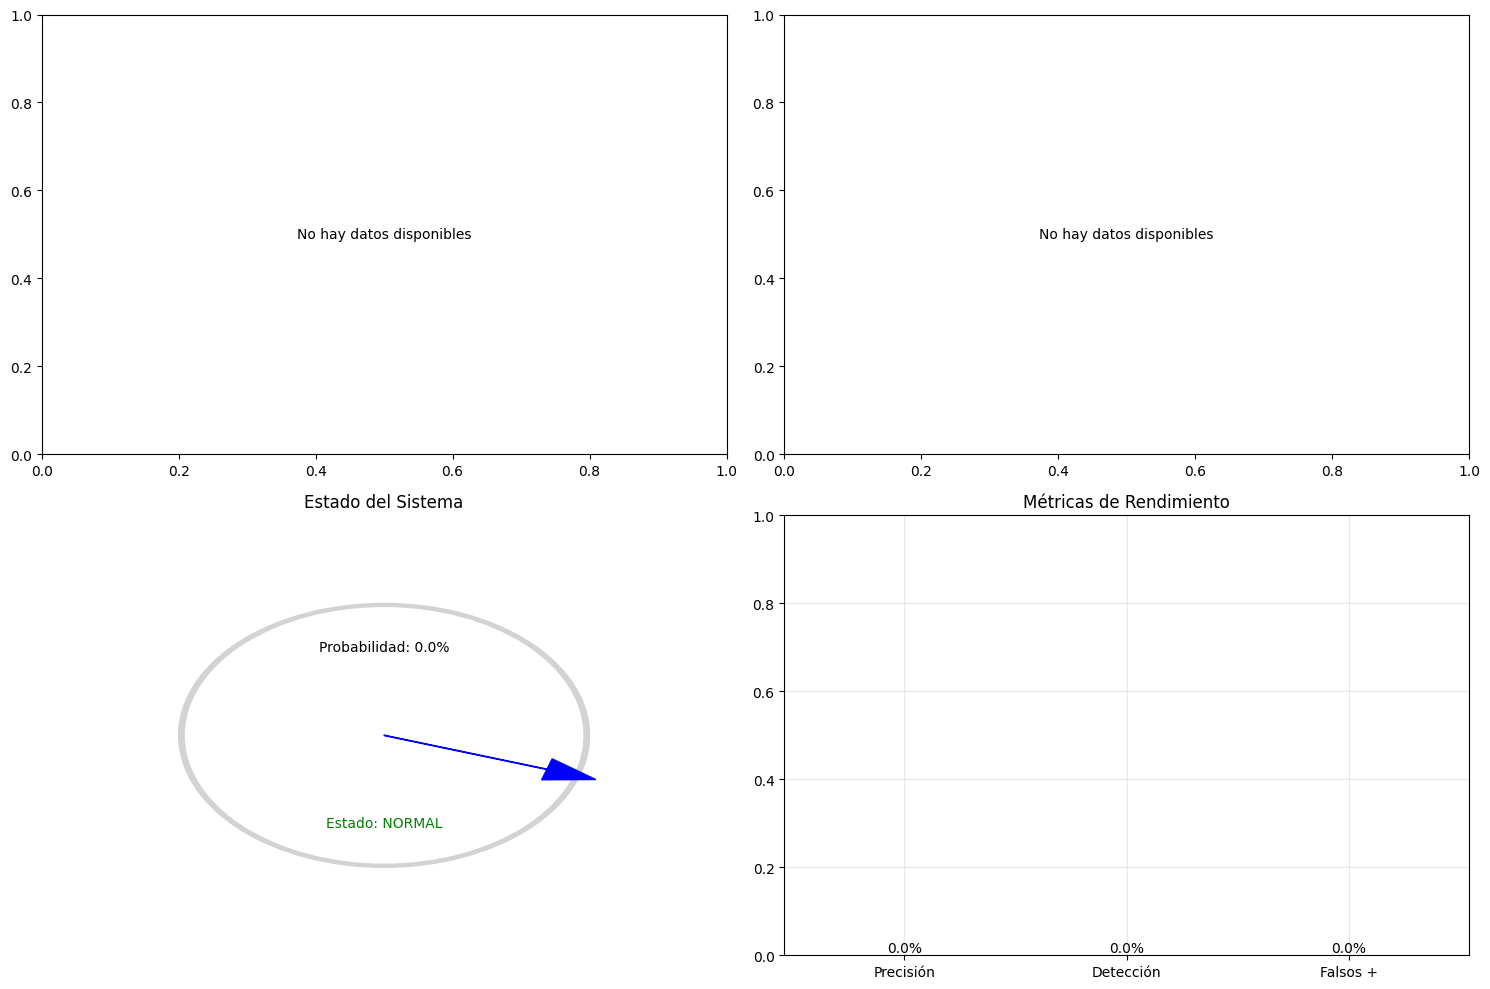

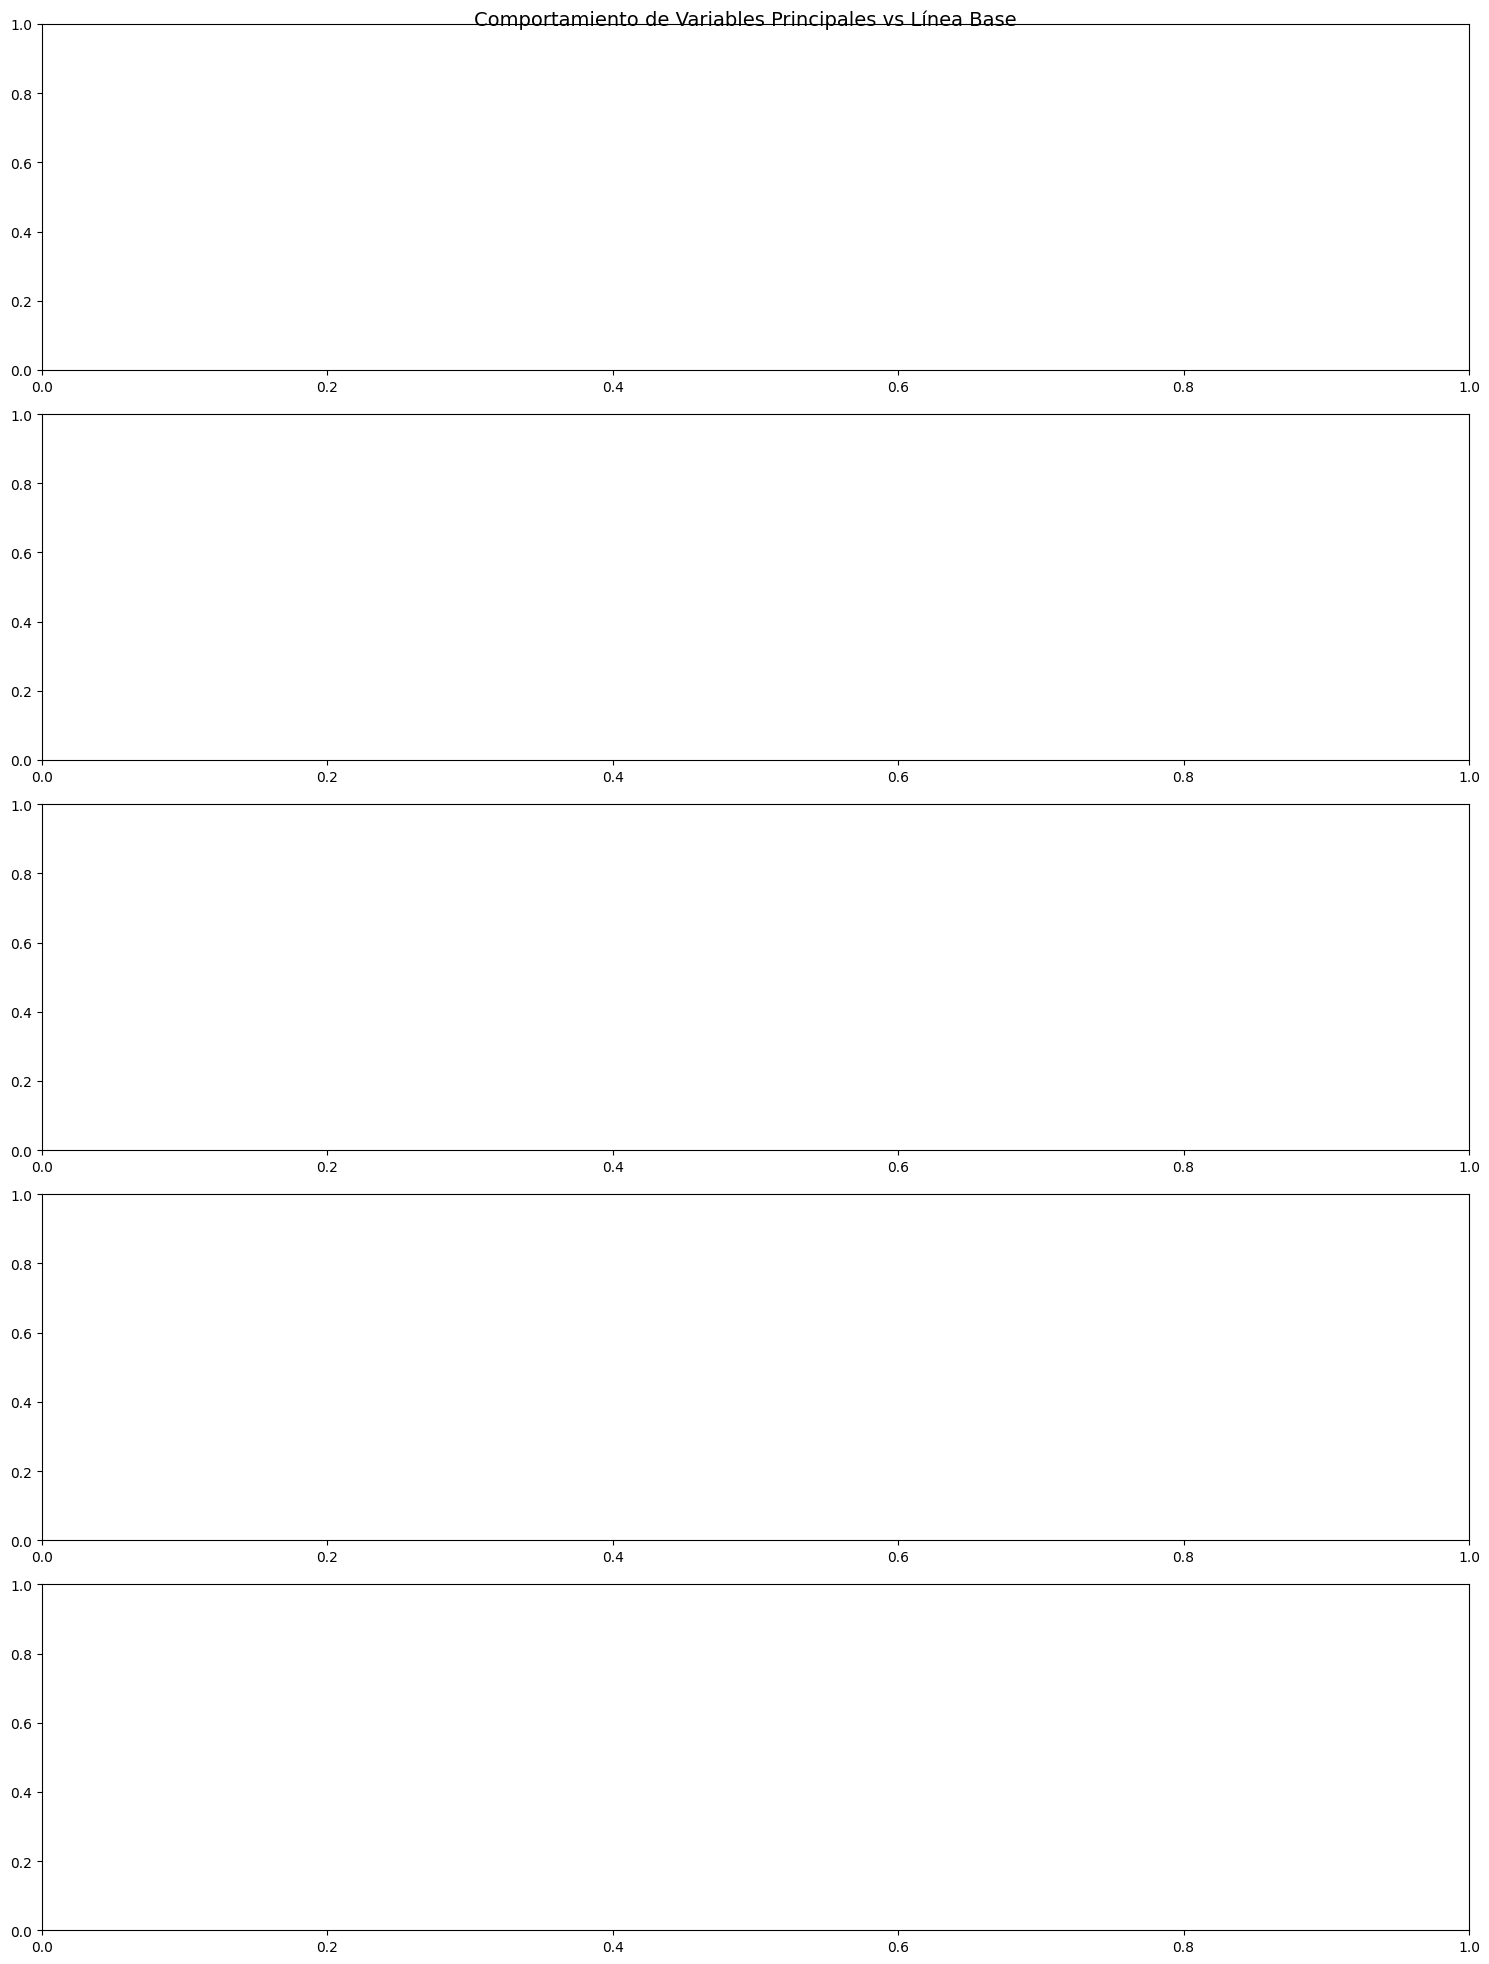


=== REPORTE DE PREDICCIÓN DE FALLAS ===

Fecha: 2025-03-29 13:40:35

Estado del Sistema:
- Probabilidad: 0.0%
- Estado: NORMAL

Variables Críticas:


In [5]:
# CELDA 5: Fase 4 - Sistema de Predicción de Fallas Industrial
"""
Sistema de Predicción de Fallas Industrial
========================================

Objetivo: 
Predecir la probabilidad de fallas mediante la comparación del comportamiento actual 
contra la línea base establecida.

Características:
- Predicción basada en desviaciones de la línea base
- Sistema de alertas tempranas
- Visualización clara de probabilidades y riesgos
- Agnóstico al tipo de datos/industria
"""
from matplotlib.dates import DateFormatter
from typing import Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from typing import Dict, List, Any, Tuple, Optional
import logging
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class IndustrialFailurePredictor:
    """Sistema de predicción de fallas basado en línea base adaptativa."""
    
    def __init__(self, baseline_learner):
        if baseline_learner is None:
            raise ValueError("El baseline_learner no puede ser None")
            
        self.baseline = baseline_learner
        self.thresholds = {
            'warning': 0.7,
            'critical': 0.9,
            'min_deviation': 0.1
        }
        
        self.predictions = {
            'current': {},
            'trends': {},
            'alerts': [],
            'system_health': {
                'probability': 0.0,
                'status': 'normal'
            }
        }
        
        self.performance = {
            'accuracy': 0.0,
            'false_positives': 0.0,
            'detection_rate': 0.0,
            'response_time': 0.0
        }
        
        # Agregar atributo para datos actuales
        self.current_data = None
        
        self._setup_logging()

        
    def _setup_logging(self):
        """Configura sistema de logging."""
        self.logger = logging.getLogger(__name__)
        formatter = logging.Formatter(
            '%(asctime)s - %(levelname)s - %(message)s'
        )
        handler = logging.StreamHandler()
        handler.setFormatter(formatter)
        self.logger.addHandler(handler)
        self.logger.setLevel(logging.INFO)

    def predict_failures(self, current_data: pd.DataFrame) -> Dict[str, Any]:
        """Método principal para predicción de fallas."""
        try:
            self.logger.info("Iniciando predicción de fallas...")
            
            # Guardar datos actuales
            self.current_data = current_data
            
            # 1. Calcular desviaciones de línea base
            deviations = self._calculate_deviations(current_data)
            
            # 2. Analizar tendencias
            trends = self._analyze_trends(current_data)
            
            # 3. Calcular probabilidades
            probabilities = self._calculate_probabilities(deviations, trends)
            
            # 4. Generar alertas
            alerts = self._generate_alerts(probabilities)
            
            # 5. Actualizar estado del sistema
            self._update_system_health(probabilities)
            
            # 6. Guardar resultados
            self.predictions.update({
                'current': probabilities,
                'trends': trends,
                'alerts': alerts
            })
            
            return self.predictions
            
        except Exception as e:
            self.logger.error(f"Error en predicción: {str(e)}")
            return None

    def _calculate_deviations(self, data: pd.DataFrame) -> Dict[str, Dict[str, float]]:
        """Calcula desviaciones respecto a la línea base."""
        deviations = {}
        
        for variable in data.columns:
            if variable not in self.baseline.results['adaptive_limits']:
                continue
                
            limits = self.baseline.results['adaptive_limits'][variable]
            current_values = data[variable].values
            
            # Calcular desviaciones normalizadas
            baseline_mean = limits['baseline']
            range_size = limits['upper'] - limits['lower']
            
            if range_size > 0:
                normalized_dev = (current_values - baseline_mean) / range_size
                
                deviations[variable] = {
                    'mean_deviation': float(np.mean(np.abs(normalized_dev))),
                    'max_deviation': float(np.max(np.abs(normalized_dev))),
                    'out_of_limits': float(np.mean(
                        (current_values > limits['upper']) | 
                        (current_values < limits['lower'])
                    ))
                }
            
        return deviations

    def _analyze_trends(self, data: pd.DataFrame) -> Dict[str, Dict[str, float]]:
        """Analiza tendencias en los datos actuales."""
        trends = {}
        
        for variable in data.columns:
            if variable not in self.baseline.results['adaptive_limits']:
                continue
                
            values = data[variable].values
            if len(values) < 2:
                continue
                
            # Calcular tendencia
            x = np.arange(len(values))
            slope, intercept = np.polyfit(x, values, 1)
            
            # Calcular dirección y fuerza de la tendencia
            trend_strength = abs(slope) * len(values) / np.std(values) if np.std(values) > 0 else 0
            
            trends[variable] = {
                'slope': float(slope),
                'direction': 'increasing' if slope > 0 else 'decreasing',
                'strength': float(trend_strength)
            }
            
        return trends

    def _calculate_probabilities(
        self, 
        deviations: Dict[str, Dict[str, float]], 
        trends: Dict[str, Dict[str, float]]
    ) -> Dict[str, float]:
        """Calcula probabilidades de falla por variable."""
        probabilities = {}
        
        for variable in deviations.keys():
            # Factores de probabilidad
            deviation_factor = min(1.0, deviations[variable]['mean_deviation'])
            limit_factor = min(1.0, deviations[variable]['out_of_limits'])
            
            trend_factor = 0.0
            if variable in trends:
                trend_factor = min(1.0, trends[variable]['strength'])
            
            # Probabilidad ponderada
            probability = (
                0.4 * deviation_factor +
                0.4 * limit_factor +
                0.2 * trend_factor
            )
            
            probabilities[variable] = float(probability)
            
        return probabilities

    def _generate_alerts(self, probabilities: Dict[str, float]) -> List[Dict[str, Any]]:
        """Genera alertas basadas en probabilidades."""
        alerts = []
        
        for variable, prob in probabilities.items():
            if prob >= self.thresholds['critical']:
                alerts.append({
                    'timestamp': datetime.now(),
                    'variable': variable,
                    'level': 'CRITICAL',
                    'probability': prob,
                    'message': f"Alta probabilidad de falla en {variable}"
                })
            elif prob >= self.thresholds['warning']:
                alerts.append({
                    'timestamp': datetime.now(),
                    'variable': variable,
                    'level': 'WARNING',
                    'probability': prob,
                    'message': f"Posible falla en {variable}"
                })
                
        return alerts

    def _update_system_health(self, probabilities: Dict[str, float]):
        """Actualiza estado general del sistema."""
        if not probabilities:
            return
            
        # Probabilidad del sistema
        system_prob = np.mean(list(probabilities.values()))
        
        # Estado del sistema
        if system_prob >= self.thresholds['critical']:
            status = 'critical'
        elif system_prob >= self.thresholds['warning']:
            status = 'warning'
        else:
            status = 'normal'
            
        self.predictions['system_health'].update({
            'probability': float(system_prob),
            'status': status
        })

    def _plot_probabilities(self, ax):
        """Visualiza probabilidades de falla por variable."""
        probabilities = self.predictions['current']
        if not probabilities:
            ax.text(0.5, 0.5, "No hay datos disponibles",
                   ha='center', va='center')
            return
            
        variables = list(probabilities.keys())
        values = list(probabilities.values())
        
        # Crear barras
        bars = ax.bar(variables, values)
        
        # Colorear según umbral
        for bar, value in zip(bars, values):
            if value >= self.thresholds['critical']:
                bar.set_color('red')
            elif value >= self.thresholds['warning']:
                bar.set_color('yellow')
            else:
                bar.set_color('green')
        
        ax.set_title('Probabilidad de Falla por Variable')
        ax.set_ylim(0, 1)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)


    

    
    def _plot_critical_variables(self, ax):
        """Visualiza top variables críticas."""
        probabilities = self.predictions['current']
        if not probabilities:
            ax.text(0.5, 0.5, "No hay datos disponibles",
                   ha='center', va='center')
            return
            
        # Ordenar por probabilidad
        sorted_vars = sorted(
            probabilities.items(),
            key=lambda x: x[1],
            reverse=True
        )[:5]  # Top 5
        
        variables, values = zip(*sorted_vars)
        
        # Crear barras horizontales
        bars = ax.barh(variables, values)
        
        # Colorear según umbral
        for bar, value in zip(bars, values):
            if value >= self.thresholds['critical']:
                bar.set_color('red')
            elif value >= self.thresholds['warning']:
                bar.set_color('yellow')
            else:
                bar.set_color('green')
        
        ax.set_title('Top Variables Críticas')
        ax.set_xlim(0, 1)
        ax.grid(True, alpha=0.3)

    def _plot_system_health(self, ax):
        """Visualiza estado general del sistema."""
        health = self.predictions['system_health']
        prob = health['probability']
        status = health['status']
        
        # Crear gauge chart simple
        ax.add_patch(plt.Circle((0.5, 0.5), 0.3, color='lightgray'))
        ax.add_patch(plt.Circle((0.5, 0.5), 0.29, color='white'))
        
        # Agregar indicador
        angle = np.pi * (0.8 * prob - 0.1)
        dx = 0.25 * np.cos(angle)
        dy = 0.25 * np.sin(angle)
        ax.arrow(0.5, 0.5, dx, dy, head_width=0.05, color='blue')
        
        # Texto
        ax.text(0.5, 0.7, f"Probabilidad: {prob:.1%}",
                ha='center', va='center')
        ax.text(0.5, 0.3, f"Estado: {status.upper()}",
                ha='center', va='center',
                color='red' if status == 'critical' else 'orange' if status == 'warning' else 'green')
        
        ax.set_title('Estado del Sistema')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')

    def _plot_performance(self, ax):
        """Visualiza métricas de rendimiento."""
        metrics = [
            ('Precisión', self.performance['accuracy']),
            ('Detección', self.performance['detection_rate']),
            ('Falsos +', self.performance['false_positives'])
        ]
        
        labels, values = zip(*metrics)
        
        bars = ax.bar(labels, values)
        
        ax.set_title('Métricas de Rendimiento')
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)
        
        # Añadir valores
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1%}',
                    ha='center', va='bottom')

    def _plot_variables_baseline(self, data: pd.DataFrame, num_vars: int = 5) -> plt.Figure:
        """
        Visualiza las variables principales con su línea base y límites.
        
        Args:
            data: DataFrame con los datos actuales
            num_vars: Número de variables principales a mostrar
        
        Returns:
            plt.Figure: Figura con los gráficos
        """
        # Obtener top variables
        top_vars = sorted(
            self.predictions['current'].items(),
            key=lambda x: x[1],
            reverse=True
        )[:num_vars]
        
        # Crear figura
        fig, axes = plt.subplots(num_vars, 1, figsize=(15, 4*num_vars))
        fig.suptitle('Comportamiento de Variables Principales vs Línea Base', fontsize=14)
        
        # Asegurar que axes sea un array incluso con una sola variable
        if num_vars == 1:
            axes = [axes]
        
        for idx, (var_name, prob) in enumerate(top_vars):
            ax = axes[idx]
            
            # Obtener datos
            values = data[var_name].values
            limits = self.baseline.results['adaptive_limits'][var_name]
            
            # Crear timestamps para el eje x
            if 'timestamp' in data.columns:
                timestamps = pd.to_datetime(data['timestamp'])
            else:
                timestamps = pd.date_range(
                    end=datetime.now(),
                    periods=len(values),
                    freq='H'
                )
            
            # Graficar línea base y límites
            ax.axhline(y=limits['baseline'], color='g', linestyle='--', label='Línea Base')
            ax.axhline(y=limits['upper'], color='r', linestyle=':', label='Límite Superior')
            ax.axhline(y=limits['lower'], color='r', linestyle=':', label='Límite Inferior')
            
            # Graficar valores actuales
            ax.plot(timestamps, values, 'b-', label='Valor Actual', linewidth=2)
            
            # Colorear zonas
            ax.fill_between(timestamps, limits['upper'], 
                            [max(values)*1.1]*len(values),
                            color='red', alpha=0.1,
                            label='Zona de Riesgo')
            ax.fill_between(timestamps, limits['lower'], 
                            limits['upper'],
                            color='green', alpha=0.1,
                            label='Zona Normal')
            ax.fill_between(timestamps, 
                            [min(values)*0.9]*len(values),
                            limits['lower'],
                            color='red', alpha=0.1)
            
            # Configurar gráfico
            ax.set_title(f'{var_name} (Prob. Falla: {prob:.1%})')
            ax.grid(True, alpha=0.3)
            ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
            
            # Formato del eje x
            ax.xaxis.set_major_formatter(DateFormatter('%H:%M\n%d-%m'))
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)
            
            # Ajustar márgenes para evitar corte de etiquetas
            ax.margins(x=0.02)
            
        # Ajustar espaciado entre subplots
        plt.tight_layout()
        
        return fig
    
    def visualize_results(self) -> Tuple[plt.Figure, plt.Figure]:
        """Genera visualización completa de resultados."""
        if self.current_data is None:
            raise ValueError("No hay datos disponibles para visualizar")
            
        # Panel principal
        plt.style.use('default')
        fig1 = plt.figure(figsize=(15, 10))
        gs = GridSpec(2, 2, figure=fig1)
        
        # 1. Probabilidades por variable
        ax1 = fig1.add_subplot(gs[0, 0])
        self._plot_probabilities(ax1)
        
        # 2. Variables críticas
        ax2 = fig1.add_subplot(gs[0, 1])
        self._plot_critical_variables(ax2)
        
        # 3. Estado del sistema
        ax3 = fig1.add_subplot(gs[1, 0])
        self._plot_system_health(ax3)
        
        # 4. Métricas de rendimiento
        ax4 = fig1.add_subplot(gs[1, 1])
        self._plot_performance(ax4)
        
        plt.tight_layout()
        
        # Panel de variables vs línea base
        fig2 = self._plot_variables_baseline(self.current_data)
        
        return fig1, fig2
            
    def generate_report(self) -> str:
        """Genera reporte detallado en texto."""
        report = [
            "\n=== REPORTE DE PREDICCIÓN DE FALLAS ===\n",
            f"Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
            f"\nEstado del Sistema:",
            f"- Probabilidad: {self.predictions['system_health']['probability']:.1%}",
            f"- Estado: {self.predictions['system_health']['status'].upper()}\n",
            
            "Variables Críticas:"
        ]
        
        # Agregar variables críticas
        sorted_vars = sorted(
            self.predictions['current'].items(),
            key=lambda x: x[1],
            reverse=True
        )
        
        for var, prob in sorted_vars:
            report.append(f"- {var}: {prob:.1%}")
        
        # Agregar alertas
        if self.predictions['alerts']:
            report.append("\nAlertas Activas:")
            for alert in self.predictions['alerts']:
                report.append(
                    f"- {alert['level']}: {alert['message']} "
                    f"(Prob: {alert['probability']:.1%})"
                )
        
        return "\n".join(report)

def execute_prediction_system(baseline_learner):
    """Ejecuta el sistema de predicción de fallas"""
    try:
        # 1. Verificar que tenemos el baseline_learner
        if baseline_learner is None:
            raise ValueError("Debe proporcionar un baseline_learner válido")
        
        # 2. Crear predictor usando la línea base existente
        predictor = IndustrialFailurePredictor(baseline_learner)
        
        # 3. Obtener las variables procesadas
        variables = list(baseline_learner.results['adaptive_limits'].keys())
        if not variables:
            raise ValueError("No hay variables procesadas en el baseline_learner")
            
        logging.info(f"Procesando predicciones para {len(variables)} variables")
        
        try:
            # Crear DataFrame con timestamp como índice
            current_data = pd.DataFrame()
            
            # Obtener todos los datos históricos para la primera variable
            first_var = variables[0]
            query = f"""
                SELECT timestamp, {first_var}
                FROM normalized_data_table
                ORDER BY timestamp;
            """
            first_data = pd.read_sql_query(query, baseline_learner.db.engine, parse_dates=['timestamp'])
            
            if first_data.empty:
                raise ValueError(f"No hay datos para la variable {first_var}")
                
            # Establecer el índice de tiempo
            current_data['timestamp'] = first_data['timestamp']
            current_data.set_index('timestamp', inplace=True)
            
            # Agregar datos de cada variable
            for var in variables:
                query = f"""
                    SELECT timestamp, {var}
                    FROM normalized_data_table
                    ORDER BY timestamp;
                """
                data = pd.read_sql_query(query, baseline_learner.db.engine, parse_dates=['timestamp'])
                if not data.empty:
                    current_data[var] = data[var]
                    logging.info(f"Variable {var}: {len(data)} registros históricos cargados")
                else:
                    logging.warning(f"No hay datos para la variable {var}")
            
            logging.info(f"DataFrame final: {current_data.shape[0]} registros x {current_data.shape[1]} variables")
            logging.info(f"Rango de fechas: {current_data.index.min()} a {current_data.index.max()}")
            
            # Verificar que tenemos datos
            if current_data.empty or current_data.shape[1] == 0:
                raise ValueError("No se obtuvieron datos para ninguna variable")
                
        except Exception as e:
            logging.error(f"Error obteniendo datos históricos: {str(e)}")
            raise
                
        # 5. Ejecutar predicción
        results = predictor.predict_failures(current_data)
        
        if results:
            try:
                # 6. Visualizar resultados
                fig1, fig2 = predictor.visualize_results()
                plt.show()
                
                # 7. Mostrar reporte
                print(predictor.generate_report())
                
                return predictor
            except Exception as e:
                print(f"Error en la visualización: {str(e)}")
                return predictor
        else:
            print("Error en la predicción")
            return None

    except Exception as e:
        print(f"Error en la ejecución: {str(e)}")
        return None
# Ejecutar el sistema de predicción
if __name__ == "__main__":
    if 'baseline_learner' in locals() and baseline_learner is not None:
        predictor = execute_prediction_system(baseline_learner)
    else:
        print("Debe ejecutar primero la Fase 3 (Línea Base Adaptativa)")